# NLP Project

Dataset:  Yelp reviews dataset

Tasks:  Analysis of the dataset, Star rating prediction, Sentiment analysis

Authors

*   Andrea Alari
*   Francesco Barisani
*   Elisa Composta
*   Simone Scevaroli

# Import and dependencies

In [1]:
import gc
import string
import re
from PIL import Image
import numpy as np
import polars as pl
import pandas as pd
from random import random
from tqdm import tqdm
import torch
import copy
from itertools import chain

from datasets import Dataset, DatasetDict, load_dataset
from collections import Counter

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
import seaborn as sns

import optuna

!pip install rank_bm25
from rank_bm25 import BM25Okapi

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.layers import TextVectorization
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

from catboost import CatBoostClassifier

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

!pip install flair
from flair.data import Sentence
from flair.models import SequenceTagger

2024-05-25 15:32:47.923682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 15:32:47.923797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 15:32:48.065966: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 88.8 MB/s eta 0:00:00:00:010:01
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=efdb1c7fa78315cdc629e4647aa8dff6cfa3153b3782183a739e0c99b81ec01c
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
  Created wheel for pptree: filename=pptree-3.1-py3-none-any.whl size=4608 sha256=7fa3baa949c8bc604bf5db2f71617ff093c11caf304f0618f6308666d17c12a3
  Stored in directory: /root/.cache/pip/wheels/9f/

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

# Custom Functions

We first define all the functions that will be useful later in the notebook

## Data Analysis Functions

In [3]:
def sort_dict(dictionary, descending = True):
    return {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1], reverse = descending)}

In [4]:
def plot_distribution(dic, first_n = None, y_log = False, title=None, x_label=None, y_label=None):
    if not first_n is None:
        y = list(dic.values())[:first_n]
        x = list(dic.keys())[:first_n]
    else:
        y = list(dic.values())
        x = list(dic.keys())
    plt.plot(x,y)
    if y_log:
        plt.yscale("log")
    if not title is None:
        plt.title(title)
    if not x_label is None:
        plt.xlabel(x_label)
    if not y_label is None:
        plt.ylabel(y_label)
    plt.show()

In [5]:
def from_dataset_to_pl(dataset, typ='train'):
    ds = dataset[typ]
    print(f'-----{typ} Dataset-----')
    print(f"N elements : {ds.shape[0]}")
    unique_ids = np.arange(0, ds.shape[0])
    data = {'index' : unique_ids, 'label' : ds['label'], 'text': ds['text']}
    df = pl.DataFrame(data)
    n_labels = df.group_by('label').len().sort('label')
    for row in n_labels.iter_rows():
        print(f'Label : {row[0]} Items : {row[1]}')
    print('-------------------------')
    return df

In [6]:
def plot_two_distributions(dic, title, first_n):
    figure, axis = plt.subplots(1, 2)
    axis[0].plot(list(dic.values())[:first_n])
    axis[0].set_title(title)

    axis[1].plot(list(dic.values())[:first_n])
    axis[1].set_title("Log scaled Occurrences")
    axis[1].set_yscale("log")

    figure.set_figheight(6)
    figure.set_figwidth(18)
    plt.show()

In [7]:
def plot_ratings(df, col='label', title=None):
    ds_labels = df[col].value_counts()
    ds_labels.sort_index(inplace=True)
    plt.figure(figsize=(4,3))
    ax = ds_labels.plot(kind="bar")
    ax.set_xlabel(col)
    ax.set_ylabel("Reviews")
    if title is not None:
        ax.set_title(title)
    plt.show()

In [8]:
def create_balanced_subset(df, label_column, sample_size):
    balanced_subset = df.groupby(label_column, group_keys=False).apply(lambda x: x.sample(sample_size), include_groups=False)
    balanced_subset[label_column] = df[label_column].reindex(balanced_subset.index)
    balanced_subset = balanced_subset.sample(frac=1).reset_index(drop=True)
    return balanced_subset

## Clustering Functions


In [9]:
def tune_topic_model(X_train, X_test):
    vectorizer = CountVectorizer(stop_words='english', max_features = 5000, max_df = 0.75)
    vector_documents = vectorizer.fit_transform(X_test)
    perplexity_values = []
    print('Running optimization...')
    for components in tqdm(range(1,50)):
        lda = LatentDirichletAllocation(n_components=components, verbose=0, learning_method='online', max_iter=100)
        lda.fit(vector_documents)
        perplexity_values.append(lda.perplexity(vectorizer.transform(X_test)))

    print('Optimization Done !!!')
    return np.argmin(np.array(perplexity_values)) + 1

In [10]:
def K_MeansPredictor(X, y, vectorizer, dim_reductor = None, print_details = False):
    k = len(set(y))

    kmeans = KMeans(n_clusters=k, n_init=5, random_state=42)
    if dim_reductor is not None:
        kmeans.fit(dim_reductor.fit_transform(vectorizer.fit_transform(X)))
    else: kmeans.fit(vectorizer.fit_transform(X))
    vocab = vectorizer.get_feature_names_out()

    if print_details:
        print("Top terms per cluster:")
        for i in range(kmeans.n_clusters):
            centroid = kmeans.cluster_centers_[i]
            sorted_terms = centroid.argsort()[::-1]
            print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:10]]}")

        print("Accuracy:", str(metrics.accuracy_score(y, kmeans.labels_)))
        print("Precision : ", str(metrics.precision_score(y, kmeans.labels_, labels = list(set(y)), average = 'micro')))
        print("Recall : ", str(metrics.recall_score(y, kmeans.labels_, labels = list(set(y)), average = 'micro')))
        print("F1 : ", str(metrics.f1_score(y, kmeans.labels_, labels = list(set(y)), average = 'micro')))
    f1 = metrics.f1_score(y, kmeans.labels_, labels = list(set(y)), average = 'micro')
    confusion = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y, kmeans.labels_, labels = list(set(y))))
    return f1, confusion

## Linear Classifier Functions

In [11]:
def vectorize(docs, embedding_model, useSum=True):
    vectors = np.zeros((len(docs),embedding_model.get_vector('test').shape[0]))
    for i in tqdm(range(len(docs))):
        tokens = re.sub('\W', ' ', docs[i]).lower().split()
        embeddings = [embedding_model.get_vector(token) for token in tokens if token in embedding_model]
        if (len(embeddings) > 0):
            if (useSum):
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

In [12]:
def vectorize_custom_emb(docs, embedding_model, useSum=True):
    words = list(embedding_model.wv.index_to_key)
    vectors = np.zeros((len(docs),embedding_model.wv['test'].shape[0]))
    for i in tqdm(range(len(docs))):
        tokens = re.sub('\W', ' ', docs[i]).lower().split()
        embeddings = [embedding_model.wv[token] for token in tokens if token in words]
        if (len(embeddings) > 0):
            if (useSum):
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

In [13]:
def train_logistic_regression(X_train, y_train, X_test, y_test, embedding_model, title = None):
    embeddings= vectorize(X_train, embedding_model, useSum= False)
    lr_model = LogisticRegression(max_iter=1000).fit(embeddings, y_train)
    predictions = lr_model.predict(vectorize(X_test, embedding_model, useSum= False))
    accuracy = metrics.accuracy_score(y_test, predictions)
    metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, predictions, labels = list(set(y_test)))).plot(cmap='Blues')
    if title is not None:
        plt.title(title + f' Acc : {accuracy}')
    plt.show()
    return accuracy

In [14]:
def optimize_linear_embedding(X_train, y_train, X_val, y_val):
    def linear_classifier_optimization(trial):
        params = {
                'max_iter': trial.suggest_int('iterations', 100, 1000),
                'tol': trial.suggest_float("tol", 0.0001, 0.1, log=True),
                'C': trial.suggest_float("rsm", 0.001, 1, log=True),
            }
        model = LogisticRegression(**params)
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        f1 = metrics.f1_score(y_val, predictions, average='micro')
        return f1

    study = optuna.create_study(direction='maximize', study_name='linear_classifier_optimization')
    study.optimize(linear_classifier_optimization, n_trials=100, n_jobs=1)
    return study.best_params

## Transformers Functions




In [15]:
def train_transformer(model_name, folder):
    bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(dataset['train']['label'])))
    bert = bert.to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    df_train = pd.DataFrame.from_dict(dataset['train'])
    df_test = pd.DataFrame.from_dict(dataset['test'])

    X_train, X_val, y_train, y_val = train_test_split(df_train['text'], df_train['label'], test_size=0.75, random_state=42 ,stratify = df_train['label'])

    train_data = Dataset.from_list([{'text': txt, 'label': lbl} for txt, lbl in zip(X_train, y_train)])
    val_data = Dataset.from_list([{'text': txt, 'label': lbl} for txt, lbl in zip(X_val, y_val)])
    test_data = Dataset.from_list([{'text': txt, 'label': lbl} for txt, lbl in zip(df_test['text'], df_test['label'])])

    data = DatasetDict()
    data['train'] = train_data
    data['validation'] = val_data
    data['test'] = test_data

    def tokenize_function(dataset):
        return tokenizer(dataset["text"], padding=True, truncation=True, max_length=256)
    tokenized_data = data.map(tokenize_function, batched=True)

    training_args = TrainingArguments(
        f'/kaggle/working/{folder}',
        do_eval = True,
        evaluation_strategy = 'steps',
        eval_steps = 0.1,
        save_strategy = "no",
        overwrite_output_dir =True,
        per_device_train_batch_size=32,
        num_train_epochs=1,
    )

    trainer = Trainer(
        model=bert,
        args=training_args,
        train_dataset=tokenized_data['train'].shuffle(seed=42),
        eval_dataset=tokenized_data['validation'].shuffle(seed=42).select(range(20000))
    )

    trainer.train()

    trainer.save_model(f'/kaggle/working/{folder}',)
    
    preds = trainer.predict(tokenized_data['test'])
    y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
    
    print(f'Report for ---------{model_name}------------')
    print(classification_report(dataset['test']['label'], y_pred))
    ConfusionMatrixDisplay(confusion_matrix(dataset['test']['label'], y_pred)).plot(cmap='Blues')
    plt.show()
    
    del bert, trainer
    gc.collect()
    torch.cuda.empty_cache()

In [16]:
def train_transformer_polarity(model_name, folder, df_train, df_test):
    bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    bert = bert.to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    X_train, X_val, y_train, y_val = train_test_split(df_train['text'], df_train['label'], test_size=0.75, random_state=42 ,stratify = df_train['label'])

    train_data = Dataset.from_list([{'text': txt, 'label': lbl} for txt, lbl in zip(X_train, y_train)])
    val_data = Dataset.from_list([{'text': txt, 'label': lbl} for txt, lbl in zip(X_val, y_val)])
    test_data = Dataset.from_list([{'text': txt, 'label': lbl} for txt, lbl in zip(df_test['text'], df_test['label'])])

    data = DatasetDict()
    data['train'] = train_data
    data['validation'] = val_data
    data['test'] = test_data

    def tokenize_function(dataset):
        return tokenizer(dataset["text"], padding=True, truncation=True, max_length=256)
    tokenized_data = data.map(tokenize_function, batched=True)

    training_args = TrainingArguments(
        f'/kaggle/working/{folder}',
        do_eval = True,
        evaluation_strategy = 'steps',
        eval_steps = 0.1,
        save_strategy = "no",
        overwrite_output_dir =True,
        per_device_train_batch_size=32,
        num_train_epochs=1,
    )

    trainer = Trainer(
        model=bert,
        args=training_args,
        train_dataset=tokenized_data['train'].shuffle(seed=42),
        eval_dataset=tokenized_data['validation'].shuffle(seed=42).select(range(20000))
    )

    trainer.train()

    trainer.save_model(f'/kaggle/working/{folder}',)
    
    preds = trainer.predict(tokenized_data['test'])
    y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
    
    print(f'Report for ---------{model_name}------------')
    print(classification_report(df_test['label'], y_pred, target_names=['negative', 'positive']))
    ConfusionMatrixDisplay(confusion_matrix(df_test['label'], y_pred), display_labels=['negative', 'positive']).plot(cmap='Blues')
    plt.show()
    
    gc.collect()
    torch.cuda.empty_cache()
    return trainer, tokenizer

## BM25 Utils

In [17]:
def bm25_map_label_to_sentiment(label):
    if label in [0, 1, 2]:
        return 'negative'
    elif label in [3, 4]:
        return 'positive'

def bm25_vectorize(docs):
    vectors = [None] * len(docs)
    for i in tqdm(range(len(docs))):
        item = docs[i].translate(str.maketrans('', '', string.punctuation))
        tokens = re.sub('\W', ' ', docs[i]).lower().split()
        vectors[i] = tokens
    return vectors

# Dataset download

The dataset contains a column of text reviews associated with a rating in the range 0-4. It is extracted from the Yelp Dataset Challenge 2015 data.

In [18]:
dataset = load_dataset("yelp_review_full")

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [19]:
df_train = pd.DataFrame.from_dict(dataset['train'])
df_test = pd.DataFrame.from_dict(dataset['test'])

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Analysis

In this section of preliminary analysis we begin by inspecting the dataset.

Let's inspect the first 3 rows of the training set as a sample (in a dataframe format for ease of visualization)

In [20]:
df_train[:3]

label                                               text
0      4  dr. goldberg offers everything i look for in a...
1      1  Unfortunately, the frustration of being Dr. Go...
2      3  Been going to Dr. Goldberg for over 10 years. ...

As we can see, the text column contains reviews written by clients on Yelp, each labelled with the associated star rating (in the range from 1 to 5). Each label, from 0 to 4, corresponds to a rating value from 1 to 5.

Here is an overview of the composition of the dataset

In [114]:
df = from_dataset_to_pl(dataset)

-----train Dataset-----
N elements : 650000
Label : 0 Items : 130000
Label : 1 Items : 130000
Label : 2 Items : 130000
Label : 3 Items : 130000
Label : 4 Items : 130000
-------------------------


As we can see, both the training set and the test set are composed of a balanced number of samples across the 5 labels

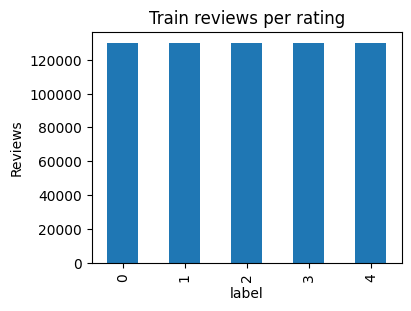

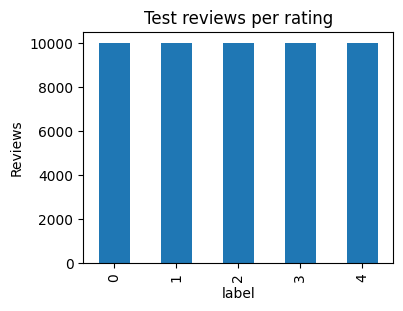

In [50]:
plot_ratings(df_train, title='Train reviews per rating')
plot_ratings(df_test, title='Test reviews per rating')

How many characters are there in the sentences? What about the number of words in each sentence?

In [51]:
min_max = df.with_columns(
        pl.col('text').str.len_bytes().alias('n_char'),
        pl.col('text').str.split(' ').list.len().alias('n_words')
)

min_max.select(['n_char']).to_numpy().squeeze()

column_to_analyze = ['char','words']
for col in column_to_analyze:
    name_col = f'n_{col}'
    print(f'Max number of {col} : {np.max(min_max.select([name_col]).to_numpy().squeeze())}')
    print(f'Min number of {col} : {np.min(min_max.select([name_col]).to_numpy().squeeze())}')
    print(f'Avg number of {col} : {np.average(min_max.select([name_col]).to_numpy().squeeze())}\n')

len_dict = dict()
for el in min_max.group_by('n_words').len().iter_rows():
    len_dict[el[0]] = el[1]
sorted_dict = dict()
for key in sorted(len_dict):
    sorted_dict[key] = len_dict[key]

Max number of char : 5637
Min number of char : 1
Avg number of char : 732.3254676923077

Max number of words : 1075
Min number of words : 1
Avg number of words : 136.74204461538463



The results are reasonable considering that we are dealing with reviews.

To get a more accurate representation of our dataset let's look at the distribution of the words in a review.

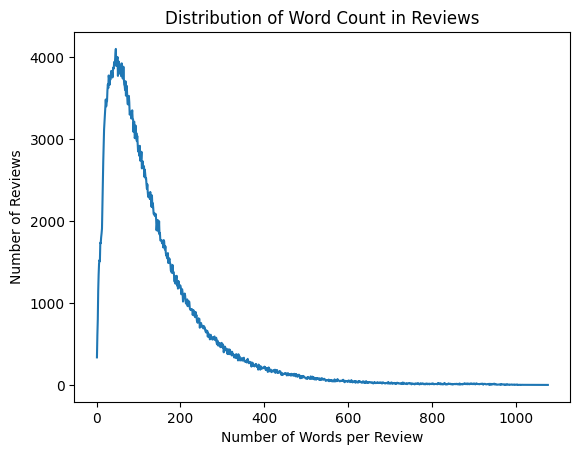

6630

In [52]:
plot_distribution(sorted_dict, title = 'Distribution of Word Count in Reviews', x_label='Number of Words per Review', y_label='Number of Reviews')

del sorted_dict, len_dict, min_max
gc.collect()

Are there any differences in terms of distribution between different classes?

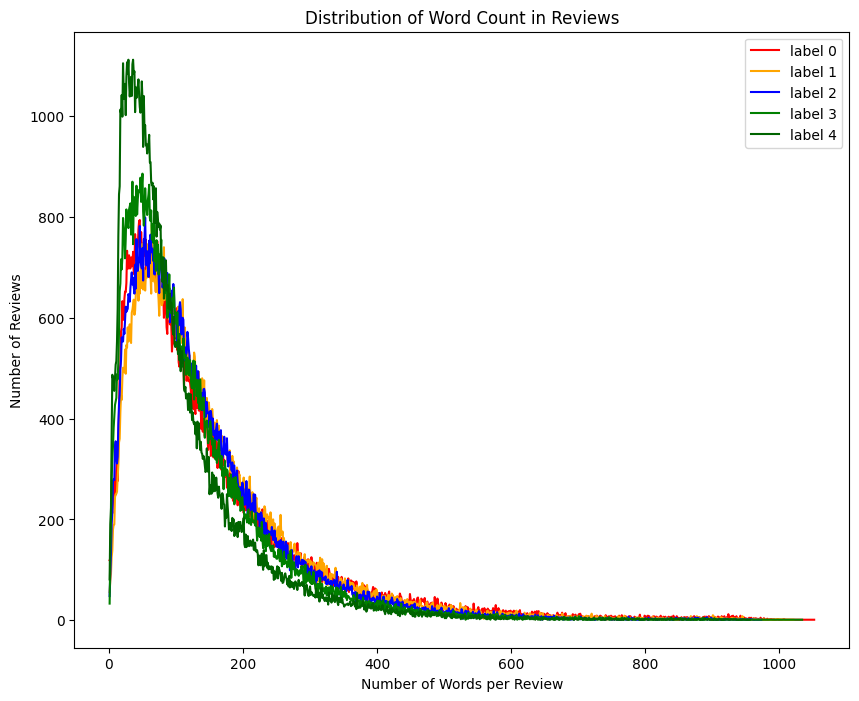

In [53]:
distributions = []
for label in range(5):
    n_words = df_train[df_train['label'] == label]['text'].str.split().str.len().to_numpy()
    n_words = pl.DataFrame({'n_words': n_words})
    len_dict = dict()
    for el in n_words.group_by('n_words').len().iter_rows():
        len_dict[el[0]] = el[1]
    sorted_dict = dict()
    for key in sorted(len_dict):
        sorted_dict[key] = len_dict[key]
    distributions.append(sorted_dict)

plt.figure(figsize=(10, 8))
plt.title('Distribution of Word Count in Reviews')
plt.xlabel('Number of Words per Review')
plt.ylabel('Number of Reviews')
colors = ['red', 'orange', 'blue', 'green', 'darkgreen']
for i in range(5):
    dic = distributions[i]
    y = list(dic.values())
    x = list(dic.keys())
    plt.plot(x, y,label = f'label {i}', color = colors[i])
plt.legend()
plt.show()

It is possible to see a slight difference between the classes, but the distributions overlap, so it is not possible to distinguish classes based on the length of the input alone.

How frequent are the most frequent words?

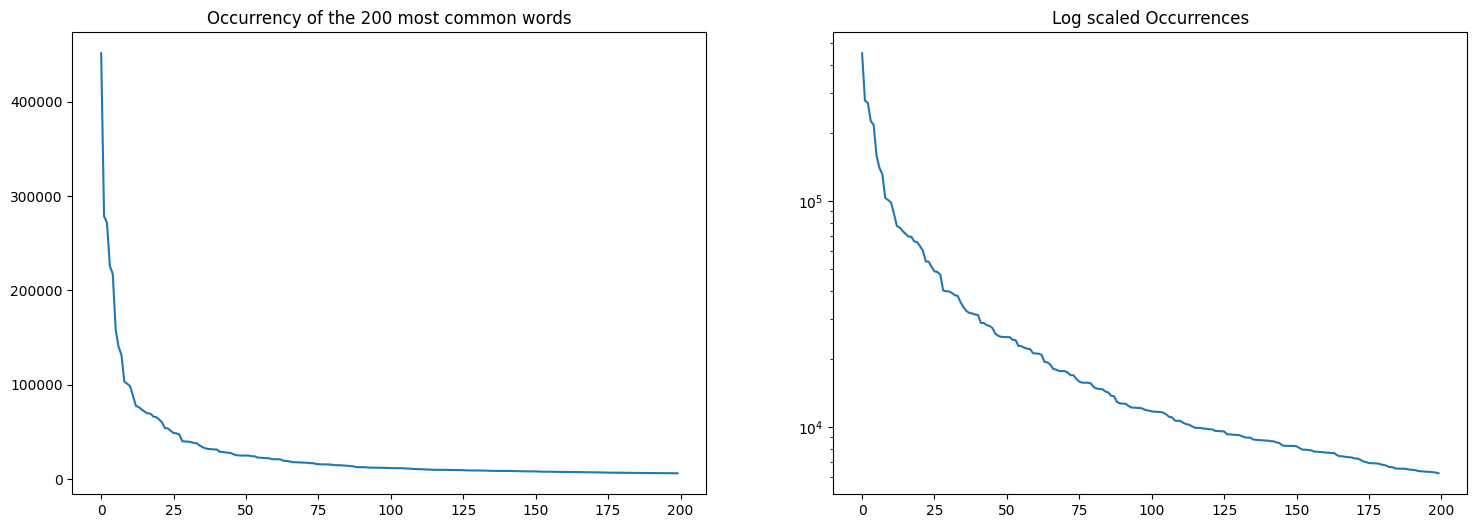

In [54]:
counts = dict()
for row in df.iter_rows():
    if random() > 0.90:
        words = (row[2].lower().replace('\\n', ' ').replace('\\"', ' ').translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))).split())
        for word in words:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1
first_n = 200
plot_two_distributions(sort_dict(counts, descending = True), f'Occurrency of the {first_n} most common words', first_n)

The curve is very steep, what happens if the stopwords are removed?

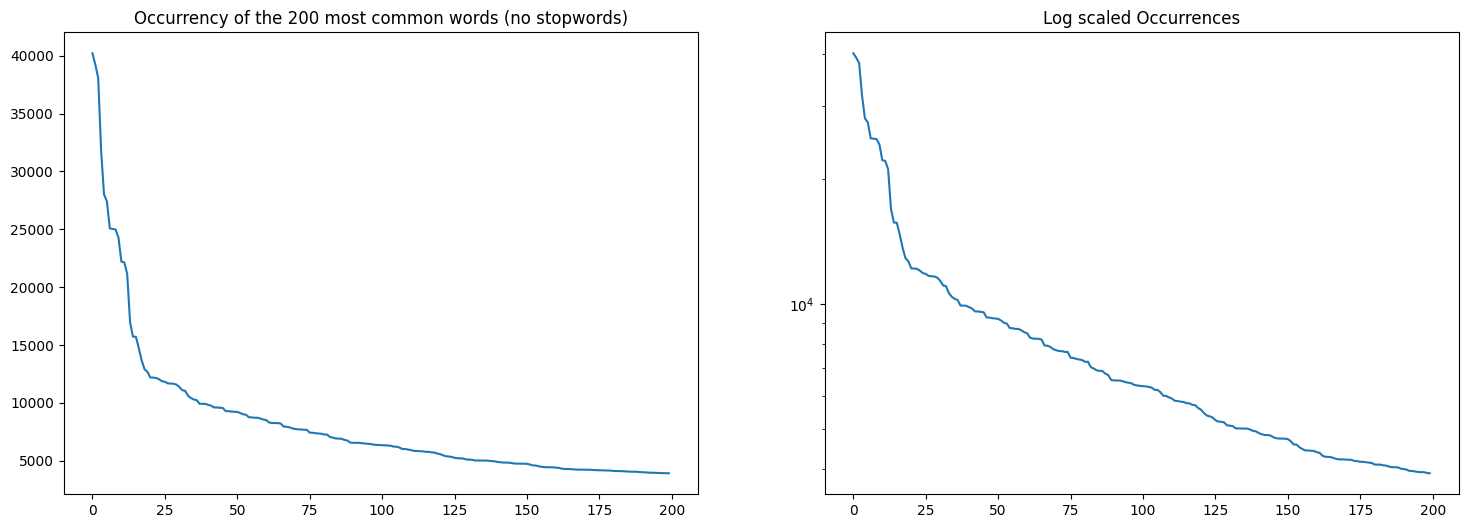

In [55]:
no_stop = dict()
for k in counts.keys():
    if k not in stopwords.words('english'):
        no_stop[k] = counts[k]
plot_two_distributions(sort_dict(no_stop, descending = True), f'Occurrency of the {first_n} most common words (no stopwords)', first_n)

Now the most common word is more than 10 time less frequent than before.

Let's see which are the most common words now compared to before.

In [56]:
print("10 most common words: ")
for item in list(sort_dict(counts, descending = True).items())[:10]:
    print(f"{item[0]}: {item[1]}")

print('\n10 most common words (no stopwords)')
for item in list(sort_dict(no_stop, descending = True).items())[:10]:
    print(f"{item[0]}: {item[1]}")

del counts, no_stop
gc.collect()

10 most common words: 
the: 451411
and: 278633
i: 271909
a: 226131
to: 217425
was: 158838
it: 140306
of: 131694
for: 103192
in: 101179

10 most common words (no stopwords)
food: 40213
good: 39240
place: 38073
like: 31841
one: 28019
get: 27418
would: 25077
time: 25024
service: 24983
great: 24260


16037

## Language recognition

The reviews are written in English, right?

To check the languages it is possible to load a model form Hugging Face that has been trained on this task. The analysis is performed on a subset of the dataset, as the inference of the model is time demanding.

In [27]:
model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt , device=device)

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

We take randomly only the 0.01% of the data and feed it to the model.

In [28]:
subsampled_dataset, _ = train_test_split(dataset['train'], test_size=0.99, stratify=dataset['train']['label'], random_state=42)
answer = pipe(subsampled_dataset['text'], top_k=1,truncation=True, batch_size=16)

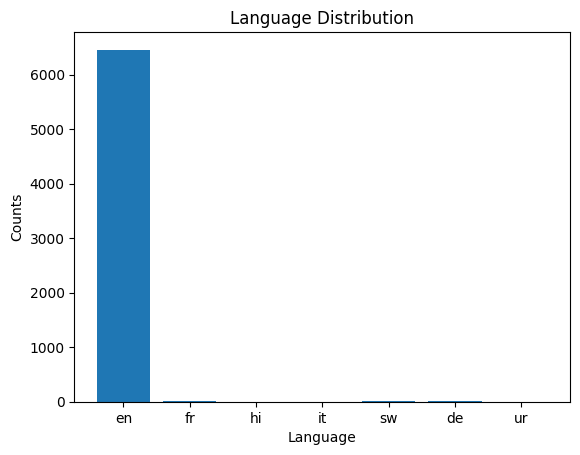

3666

In [29]:
languages = [item[0]['label'] for item in answer]
languages_counts = Counter(languages)
language = list(languages_counts.keys())
counts = list(languages_counts.values())

plt.bar(language, counts)
plt.xlabel('Language')
plt.ylabel('Counts')
plt.title('Language Distribution')
plt.show()

del pipe
gc.collect()

Almost all the sentences are in English, we decided to keep all the dataset since removing all not-English sentences would have required more than the available run-time on Kaggle.

It is also possible that the model used for the analysis had miss-classified some English sentences.

## Named Entity Recognition (NER)

We run a NER model to extract the entities in our dataset

pytorch_model.bin:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

2024-05-21 15:46:30,773 SequenceTagger predicts: Dictionary with 75 tags: O, S-PERSON, B-PERSON, E-PERSON, I-PERSON, S-GPE, B-GPE, E-GPE, I-GPE, S-ORG, B-ORG, E-ORG, I-ORG, S-DATE, B-DATE, E-DATE, I-DATE, S-CARDINAL, B-CARDINAL, E-CARDINAL, I-CARDINAL, S-NORP, B-NORP, E-NORP, I-NORP, S-MONEY, B-MONEY, E-MONEY, I-MONEY, S-PERCENT, B-PERCENT, E-PERCENT, I-PERCENT, S-ORDINAL, B-ORDINAL, E-ORDINAL, I-ORDINAL, S-LOC, B-LOC, E-LOC, I-LOC, S-TIME, B-TIME, E-TIME, I-TIME, S-WORK_OF_ART, B-WORK_OF_ART, E-WORK_OF_ART, I-WORK_OF_ART, S-FAC


100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s]


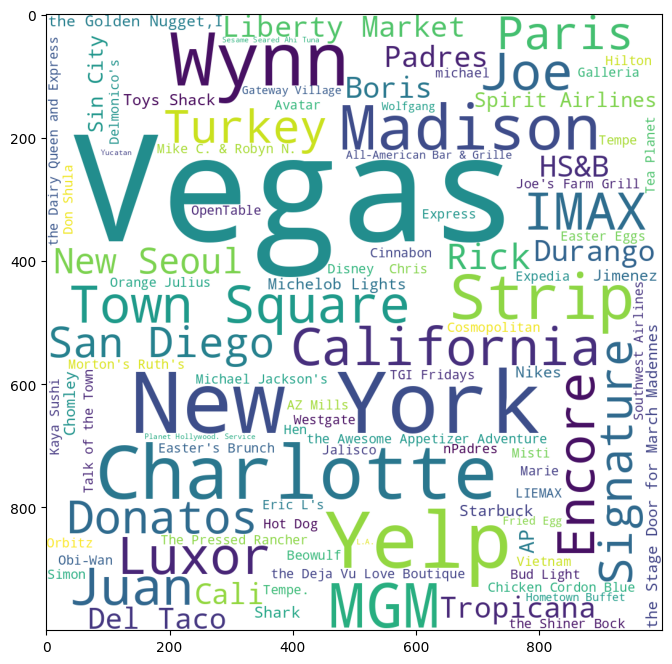

In [26]:
tagger = SequenceTagger.load("flair/ner-english-ontonotes")
sub = resample(df_train['text'], n_samples= 1000)

selected_entities = ['EVENT','FAC','GPE','LOC','ORG','PERSON','PRODUCT','WORK_OF_ART']
entity_dict = {}
for el in tqdm(sub):
    sentence = Sentence(el)
    tagger.predict(sentence)
    for entity in sentence.get_spans('ner'):
        if entity.tag in selected_entities:
            if entity.text in entity_dict.keys():
                entity_dict[entity.text] = entity_dict[entity.text] + 1
            else :
                entity_dict[entity.text] = 1

wc = WordCloud(background_color="white",width=1000,height=1000, max_words=100,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(sort_dict({k: entity_dict[k] for k in list(entity_dict)[:100]}))
plt.figure(figsize=(8, 8))
plt.imshow(wc)

This plot displays the most frequent words given the selected entities.

## Word Embedings (Word2Vec)
In this section, we will train a Word2Vec model and investigate some of the properties of the obtained embeddings.

After that, we will also make use of the t-SNE algorithm and visualization to see how the similarity affinity or distance between words results in their spatial disposition when rendered in a low-dimensional 3d space.

In [21]:
documents = [re.sub('\n', ' ', doc) for doc in df_train['text']]
documents = [re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', doc) for doc in documents]
sentences = list(chain(*[re.split('[?!.]\s', doc) for doc in documents]))

tok_sentences = [re.sub('\W', ' ', s).lower().split() for s in sentences if len(re.sub('\W', ' ', s).split()) > 1]

Now that we have prepared the data, we can create the Word2vec model.

In [22]:
w2vec_model = Word2Vec(tok_sentences, vector_size=150, min_count=5, window=10)
print(f"Number of learned embeddings: {len(w2vec_model.wv)}")

Number of learned embeddings: 71680


We now inspect the similarity of some words, according to the embeddings model, and notice how close or distant they are.

In [48]:
sample_word = 'restaurant'

print(f'Most similar: {w2vec_model.wv.most_similar(sample_word)[:5]}\n')
print(f'Most different: {w2vec_model.wv.most_similar(negative=[sample_word])[:5]}')

Most similar: [('resturant', 0.8392360806465149), ('establishment', 0.8060490489006042), ('place', 0.7740797996520996), ('eatery', 0.7619059085845947), ('restaraunt', 0.7356209754943848)]

Most different: [('michalada', 0.3049006462097168), ('thr', 0.2930457890033722), ('bought', 0.2901618480682373), ('shorted', 0.27556654810905457), ('ntowels', 0.2750283181667328)]


We notice that the results are consistent with our intuitions, since the words similar to "restaurant" belong to the same category, while the different terms are meaningless wrt the given word. 

Let's now compute the similarity between some close pairs and distant pairs of terms.

In [33]:
similar_terms = [('dish', 'plate'), ('chair', 'sofa'), ('dirt','dust')]
different_terms = [('kind','office'), ('good', 'doctor'), ('service', 'shoe')]

for t in similar_terms:
    print(f"{t}: {w2vec_model.wv.similarity(t[0], t[1])}")
print("-----------------------------------------------")
for t in different_terms:
    print(f"{t}: {w2vec_model.wv.similarity(t[0], t[1])}")

('dish', 'plate'): 0.6169195771217346
('chair', 'sofa'): 0.6300168633460999
('dirt', 'dust'): 0.7582631707191467
-----------------------------------------------
('kind', 'office'): -0.07955272495746613
('good', 'doctor'): -0.1908378154039383
('service', 'shoe'): -0.01523071900010109


As expected, similar terms receive a high score, while dissimilar terms have a low value.

### Geometric properties
Now we want to tackle one of the most famous aspect of embeddings, that is their so-called "geometric" properties.
We compute the vector distance between some relevant pairs of terms and then apply it to a given word (with a basic algebraic sum). Finally we retain only the 4 most similar words to the "resulting one".

In [38]:
operand_terms = [('waiter', 'woman', 'man'), ('dollar', 'plural', 'singular'), ('winter','hot', 'cold')]

for t in operand_terms:
    result = (w2vec_model.wv[t[0]] + (w2vec_model.wv[t[1]] - w2vec_model.wv[t[2]]))
    print(f'{t[0]} + ({t[1]} - {t[2]}) = {w2vec_model.wv.most_similar(result)[:4]}')

waiter + (woman - man) = [('waitress', 0.9430161118507385), ('server', 0.9216704964637756), ('waiter', 0.9086505770683289), ('bartender', 0.753189742565155)]
dollar + (plural - singular) = [('dollar', 0.985276997089386), ('dollars', 0.7798885703086853), ('bucks', 0.746612012386322), ('cents', 0.6602268815040588)]
winter + (hot - cold) = [('winter', 0.701888382434845), ('summer', 0.6093623638153076), ('hot', 0.5662452578544617), ('summertime', 0.5520055294036865)]


You can see that it behaves correctly, because the word that we were expecting is shown in the top four retrieved words.

Now we try to explore if the model can spot the odd word in a given set of semantically similar words.

In [43]:
groups = [('london', 'madrid', 'munich', 'diner'), ('hamburger', 'pizza', 'television', 'fries'), ('nice', 'light', 'clean', 'book')]

for t in groups:
    odd_term = w2vec_model.wv.doesnt_match(t)
    print(f'odd word in {t} is:  "{odd_term}"')

odd word in ('london', 'madrid', 'munich', 'diner') is:  "diner"
odd word in ('hamburger', 'pizza', 'television', 'fries') is:  "television"
odd word in ('nice', 'light', 'clean', 'book') is:  "book"


As we can see from the results, it correctly identifies the odd element.

### t-SNE visualization of the embeddings
Now we will explore the embeddings with the t-SNE visualization.

We start by creating a plot with a sample of 300 terms, and define a function to add to the plot the inspected words in each analysis.

In [44]:
import random
sample = random.sample(list(w2vec_model.wv.key_to_index), 300)

def plot_words(new_list):
    emb_vectors = w2vec_model.wv[new_list+sample]
    tsne = TSNE(n_components=3, n_iter=2000)
    tsne_embedding = tsne.fit_transform(emb_vectors)

    x, y, z = np.transpose(tsne_embedding)

    r = (-200,200)
    fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=new_list + [None] * 300)
    fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
    fig.show()

Let's now try to add a group of semantically related words and see if they get arranged in a cluster. <br> 
Please note that we have also added an odd term to see where it is displayed wrt the rest of the group.

In [45]:
countries = ['italy','france','germany','netherlands','spain','greece','norway','argentina','india','australia', 'diner']
plot_words(countries)

We notice that the countries correctly end up close together. Moreover, the odd term is placed far from the cluster.

As one last experiment, we take a sample word and plot its 5 most similar and different terms on the plot.

In [46]:
sample_word = 'restaurant'

similar_terms  = w2vec_model.wv.most_similar(sample_word)[:5]
different_terms = w2vec_model.wv.most_similar(negative=[sample_word])[:5]

words_list = [sample_word] + [t[0] for t in (similar_terms + different_terms)]

plot_words(words_list)

As we expected, we notice that the similar words gather around the sample one, while the dissimilar ones are spread around the space, far from the sample.

# Clustering

Let's now start trying some clustering technique on our data.

In [21]:
tf_idf_vectorizer = TfidfVectorizer(stop_words='english', max_features = 5000, max_df = 0.75)
count_vectorizer = CountVectorizer(stop_words='english', max_features = 5000, max_df = 0.75)
_, X_train, _, y_train = train_test_split(df_train['text'], df_train['label'], test_size=0.10, random_state=42 ,stratify = df_train['label'])

Using a TF-IDF and SVD let's see how our 5 classes are distributed.

In [22]:
svd = TruncatedSVD(3)
sentences_3d = svd.fit_transform(tf_idf_vectorizer.fit_transform(X_train))

x, y, z = np.transpose(sentences_3d)

fig = px.scatter_3d(x=x, y=y, z=z, color=np.array(y_train))
fig.update_traces(marker=dict(size=3,line=dict(width=2)))
fig.show()

del svd, x, y, z, sentences_3d
gc.collect()

171

Even though the classes with labels 4 and 0 are far apart, there isn't a clear division between all the classes.

Let's see if an LDA representation can help us identify our classes better.
We tune the number of topics in our LDA model by minimising perplexity.

(to tune the number of topics, set the n_components flag to None)

In [23]:
_, X_lda, _, y_lda = train_test_split(df_train['text'], df_train['label'], test_size=0.01, random_state=42 ,stratify = df_train['label'])
X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_lda, y_lda, test_size=0.20, random_state=42 ,stratify =y_lda)

In [24]:
n_components = 2
if n_components is None:
    print('Optimizing Topic Model - looking for lowest perplexity')
    n_components = tune_topic_model(X_train_lda, X_test_lda)
    print(f'N_Components : {n_components}')

print('Optimization done')
print(f'Optimal number of components : {n_components}')

Optimization done
Optimal number of components : 2


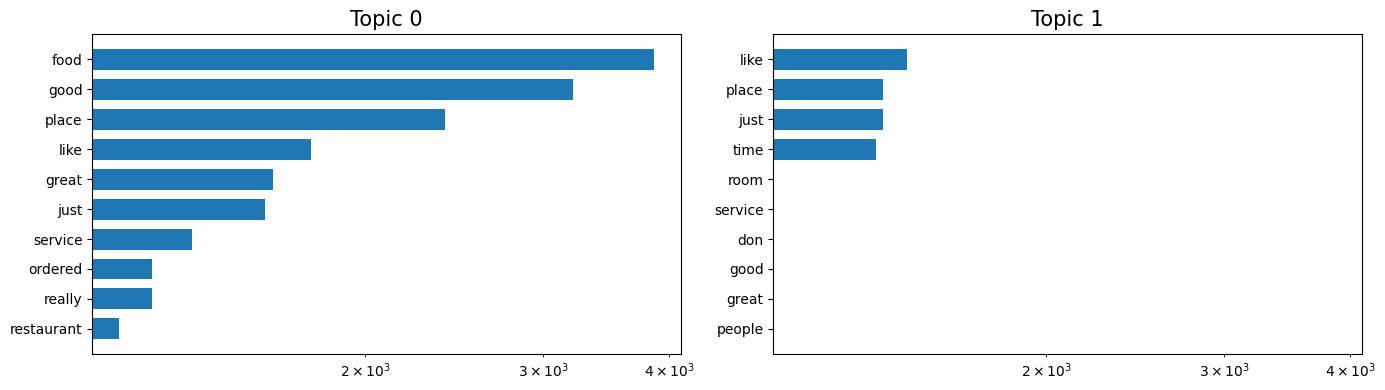

2405

In [25]:
vectorizer = CountVectorizer(stop_words='english', max_features = 5000, max_df = 0.75)
vector_documents = vectorizer.fit_transform(X_lda)
lda = LatentDirichletAllocation(n_components=n_components, verbose=0, learning_method='online', max_iter=100)
lda.fit(vector_documents)
vector_documents = vectorizer.get_feature_names_out()

num_words = 10
cols = n_components
rows = 1

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vector_documents[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

del vectorizer, vector_documents, lda
gc.collect()

Not good results so far...

How many groups are there in our data set according to KMeans?

We are looking for a knee point in the plot of WSS

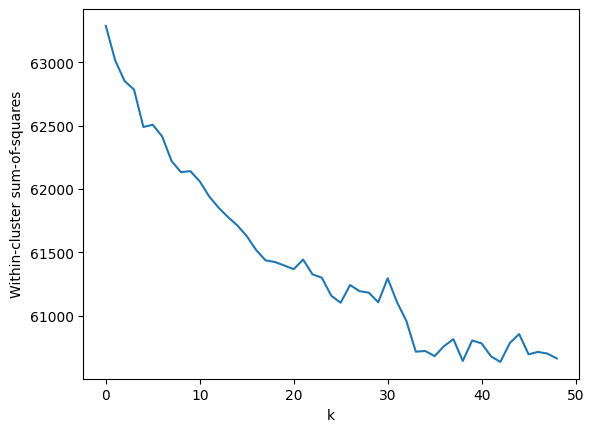

In [39]:
vector_document = tf_idf_vectorizer.fit_transform(X_train)
performance = [MiniBatchKMeans(n_clusters=k, batch_size=500, n_init='auto', random_state=42).fit(vector_document).inertia_ for k in range(1,50)]

plt.plot(performance)
plt.ylabel('Within-cluster sum-of-squares')
plt.xlabel('k')
plt.show()

It's not possible to identify a knee point, which could be due to the high dimensionality of the vectorised sets.

Which are the actual performances of this clustering methods when we used them for classification?

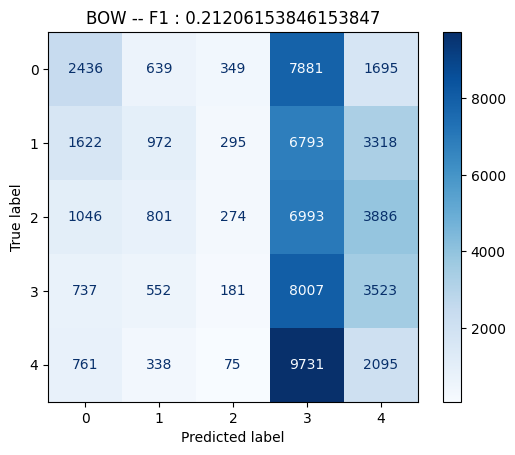

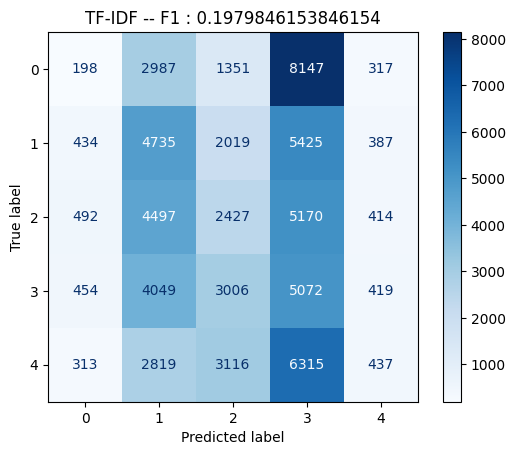

In [27]:
f1, confusion = K_MeansPredictor(X_train, y_train, count_vectorizer)
confusion.plot(cmap='Blues')
plt.title(f'BOW -- F1 : {f1}')
plt.show()

f1,confusion = K_MeansPredictor(X_train, y_train, tf_idf_vectorizer)
confusion.plot(cmap='Blues')
plt.title(f'TF-IDF -- F1 : {f1}')
plt.show()

The two models assign the majority of the items to three classes. 

Those three classes do not comply with the groud truth so the model is building relationships that are not relevant with our task

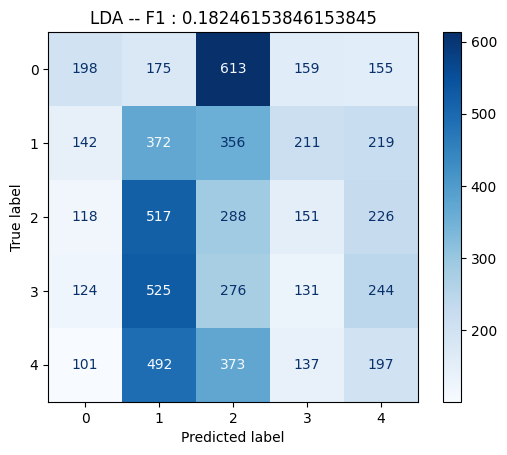

In [28]:
lda = LatentDirichletAllocation(n_components=n_components, verbose=0, learning_method='online', max_iter=100)
f1,confusion = K_MeansPredictor(X_lda, y_lda, count_vectorizer, lda)
confusion.plot(cmap='Blues')
plt.title(f'LDA -- F1 : {f1}')
plt.show()

del lda

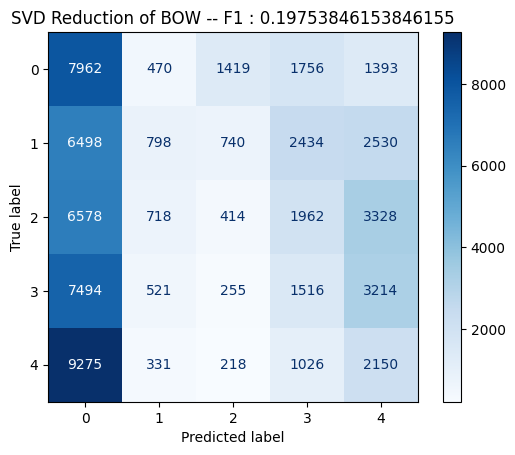

In [29]:
svd = TruncatedSVD(3)
f1, confusion = K_MeansPredictor(X_train, y_train, count_vectorizer, svd)
confusion.plot(cmap='Blues')
plt.title(f'SVD Reduction of BOW -- F1 : {f1}')
plt.show()

When we decrease the dimensionality it can be observed that previous highlighted behaviours increase, in fact most of the points belongs to a single cluster


What happens if, instead of vectorize the sentence, we embedd it using a Sentence Transformer and then a SV decomposition?

In [30]:
model = SentenceTransformer('sentence-transformers/distilbert-base-nli-mean-tokens')
embeddings = model.encode(X_train.to_numpy(), device=device)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2032 [00:00<?, ?it/s]

In [31]:
svd = TruncatedSVD(3)
sentences_3d = svd.fit_transform(embeddings)

x, y, z = np.transpose(sentences_3d)

fig = px.scatter_3d(x=x, y=y, z=z, color=np.array(y_train))
fig.update_traces(marker=dict(size=3,line=dict(width=2)))
fig.show()

del svd, sentences_3d, x, y, z
gc.collect()

21274

The spatial positioning of the sentences has changed.

Does this change increase the performance of the clustering classifier?

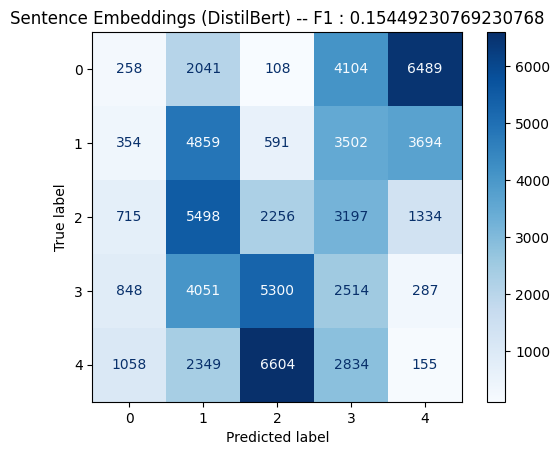

13806

In [32]:
k = len(set(y_train))
kmeans = KMeans(n_clusters=k, n_init=5, random_state=42)
kmeans.fit(embeddings)
f1 = metrics.f1_score(y_train, kmeans.labels_, labels = list(set(y_train)), average = 'micro')
confusion = ConfusionMatrixDisplay(confusion_matrix(y_train, kmeans.labels_, labels = list(set(y_train))))
confusion.plot(cmap='Blues')
plt.title(f'Sentence Embeddings (DistilBert) -- F1 : {f1}')
plt.show()

del embeddings, model, f1, confusion, kmeans, tf_idf_vectorizer, count_vectorizer
gc.collect()

There's no significant improvement in terms of performances however the predictions are more scattered than before proving that embeddings are useful if we want to move our input to a more meaningful space.

We can use a bit more sophisticated model such as a linear classifier.

# Linear Classifier

## Vectorization
Now we can try a linear classifier, the Logistic Regressor, in three variants:<br>
- Count vectorization
- TF-IDF vectorization
- Embeddings

First of all, we take a balanced subset of our original data, to make computations faster without significantly impacting the results.

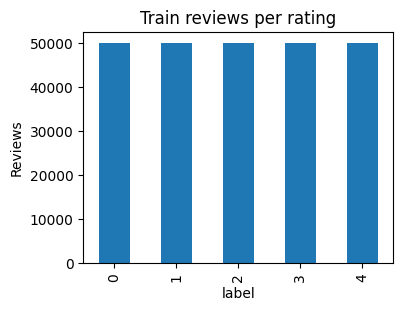

In [43]:
train_subset = create_balanced_subset(df=df_train, label_column="label", sample_size=50000)
plot_ratings(train_subset, title='Train reviews per rating')

### Count Vectorizer
Let's start with the Count Vectorizer.<br>
We set as minimum document frequency 10, and as maximum number of features 5000. We consider both unigrams and bigrams, and we remove english stopwords.

Once we have the vectorizer, we can vectorize the train text.<br>
We also vectorize the test text, but we will only use it later in the evaluation.

In [35]:
count_vectorizer = CountVectorizer(min_df=10, stop_words='english', max_features=5000, ngram_range=(1, 2))

X_train = count_vectorizer.fit_transform(train_subset['text'])
X_test = count_vectorizer.transform(df_test['text'])

y_train = train_subset['label']
y_test = df_test['label']

We now perform the tuning of the parameters of the Logistic Regressor model.<br>
Specifically, we tune _C_ and _tol_ parameters with a grid search. <br>
Please note that it's also possible to build the model with some default values, chosen from a previously run tuning.

In [36]:
tuning_on = False
solv = 'liblinear' # also tried: lbfgs, sag

if tuning_on:
    model = LogisticRegression(max_iter=100, solver=solv, warm_start=True)

    param_grid = {
        'C': [0.001, 0.01, 1.0, 10.0],
        'tol': [0.0001, 0.001, 0.01, 0.1]
    }
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f'Best parameters: {best_params}')

    logreg_count_model = grid_search.best_estimator_

else:
    logreg_count_model = LogisticRegression(max_iter=100, solver=solv, warm_start=True, C=0.01, tol=0.001)
    logreg_count_model.fit(X_train, y_train)

At this point we have built our model with the tuned parameters, so we can evaluate its performance using the test data we vectorized before.

After predicting the labels of the test set with the model, we simply display the main metrics and the confusion matrix.

              precision    recall  f1-score   support

           0       0.65      0.78      0.71     10000
           1       0.53      0.43      0.47     10000
           2       0.51      0.44      0.47     10000
           3       0.49      0.45      0.47     10000
           4       0.61      0.74      0.67     10000

    accuracy                           0.57     50000
   macro avg       0.56      0.57      0.56     50000
weighted avg       0.56      0.57      0.56     50000



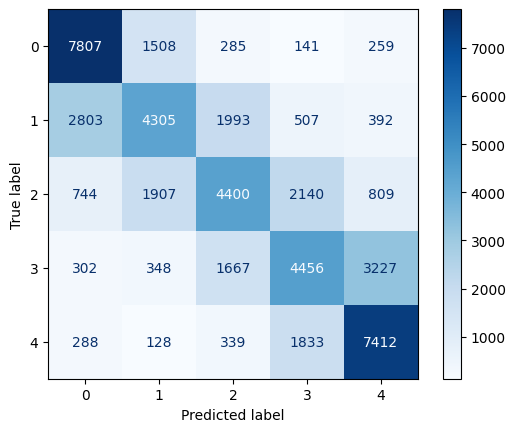

In [37]:
pred_label = logreg_count_model.predict(X_test)

print(classification_report(y_test, pred_label))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_label)).plot(cmap='Blues')
plt.show()

del logreg_count_model, count_vectorizer
gc.collect()

The confusion matrix shows that the model tends to predict values on the main diagonal, which means that the predicted labels are generally closer to the real rating.

However, we obtain a final accuracy of 0.57, which is not an exciting result, but still it's a good start!

Let's see if a different vectorization obtains better results.

### TF-IDF Vectorizer

For trying the TF-IDF vectorizer we use the same procedure: after vectorizing the train (and test) text, we tune the parameters, and we evaulate the final model on the test set.

In [44]:
tfidf_vectorizer = TfidfVectorizer(min_df=10, stop_words='english', max_features=5000, ngram_range=(1, 2))

X_train = tfidf_vectorizer.fit_transform(train_subset['text'])
X_test = tfidf_vectorizer.transform(df_test['text'])

y_train = train_subset['label']
y_test = df_test['label']

In [45]:
tuning_on = False
solv = 'sag' # also tried: lbfgs, liblinear

if tuning_on:
    model = LogisticRegression(max_iter=100, solver=solv, warm_start=True)

    param_grid = {
        'C': [0.01, 0.1, 1.0, 10.0],
        'tol': [0.0001, 0.001, 0.01]
    }
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f'Best parameters: {best_params}')

    logreg_tfidf_model = grid_search.best_estimator_

else:
    logreg_tfidf_model = LogisticRegression(solver=solv, warm_start=True, C=1.0, tol=0.01)
    logreg_tfidf_model.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.69      0.74      0.72     10000
           1       0.52      0.49      0.51     10000
           2       0.50      0.48      0.49     10000
           3       0.50      0.49      0.50     10000
           4       0.66      0.69      0.67     10000

    accuracy                           0.58     50000
   macro avg       0.57      0.58      0.58     50000
weighted avg       0.57      0.58      0.58     50000



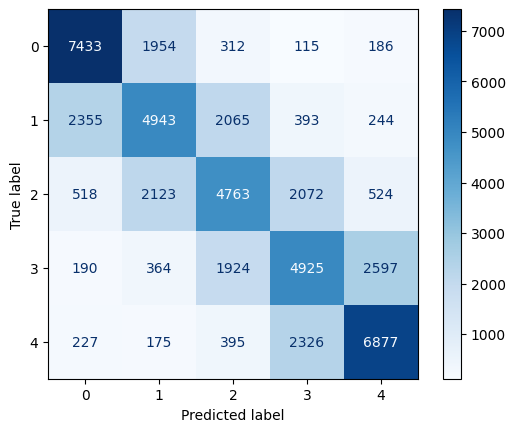

In [41]:
pred_label = logreg_tfidf_model.predict(X_test)

print(classification_report(y_test, pred_label))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_label)).plot(cmap='Blues')
plt.show()

gc.collect()

The final accuracy found by the Logistic Regressor with the TF-IDF vectorization is slightly better than the one we found before. 

### Embeddings

Let's now try to use the embeddings.

First of all, we split the train data into train and validation set, and we make sure that it is still balanced with respect to the label column.

In [29]:
X_train, X_val, y_train, y_val = train_test_split(df_train['text'], df_train['label'], test_size=0.75, random_state=42 ,stratify = df_train['label'])
X_val, y_val = resample(X_val, y_val, stratify = y_val, n_samples=20000)

In the following cell we explore different embeddings and parameter values. We then use the best parameters and embedding to build the model, which is then evaluated.

Loading model...


100%|██████████| 650000/650000 [08:25<00:00, 1286.02it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

100%|██████████| 50000/50000 [00:38<00:00, 1293.63it/s]


              precision    recall  f1-score   support

           0       0.65      0.72      0.68     10000
           1       0.46      0.45      0.45     10000
           2       0.44      0.44      0.44     10000
           3       0.45      0.42      0.43     10000
           4       0.63      0.62      0.62     10000

    accuracy                           0.53     50000
   macro avg       0.53      0.53      0.53     50000
weighted avg       0.53      0.53      0.53     50000



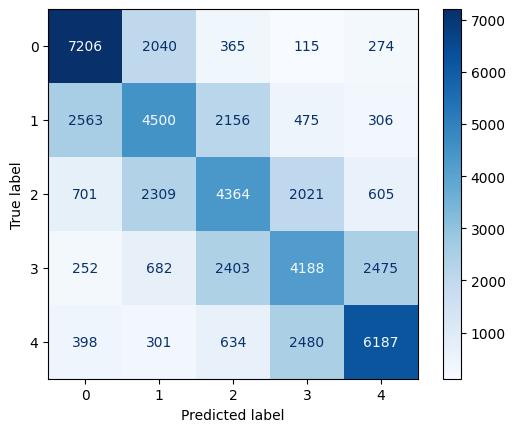

In [32]:
best_embedding = 'glove-twitter-200'
best_param = {'tol': 0.0006811855910220816, 'C': 0.8603850053519103, 'max_iter':1000}

if best_embedding is None and best_param is None:
    embeddings = ['glove-twitter-50','glove-twitter-200', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-300']
    results = [train_logistic_regression(X_train.to_numpy(), y_train.to_numpy(), df_test['text'].to_numpy(), df_test['label'].to_numpy(), api.load(emb), title = emb) for emb in embeddings]
    print(results)
    best_embedding =  embeddings[np.argmax(results)]
    print(f'Best embedding : {best_embedding}')

if best_embedding is not None and best_param is None:
    print('Optimizing...')
    embedding_model = api.load(best_embedding)
    best_param = optimize_linear_embedding(vectorize(X_train.to_numpy(), embedding_model, useSum=False), y_train.to_numpy(), vectorize(X_val.to_numpy(), embedding_model, useSum=False), y_val.to_numpy())

if best_embedding is not None and best_param is not None:
    print("Loading model...")
    embedding_model = api.load(best_embedding)
    embeddings = vectorize(df_train['text'].to_numpy(), embedding_model, useSum=False)
    lr_model = LogisticRegression(**best_param).fit(embeddings, df_train['label'].to_numpy())
    
    predictions = lr_model.predict(vectorize(df_test['text'].to_numpy(), embedding_model, useSum=False))
    print(classification_report(df_test['label'].to_numpy(), predictions))
    ConfusionMatrixDisplay(confusion_matrix(df_test['label'].to_numpy(), predictions, labels = list(set(y_test)))).plot(cmap='Blues')
    plt.show()

    del embeddings, predictions, embedding_model
    gc.collect()

The confusion matrix displayed shows that the predictions are mainly distributed along the main diagonal, and this is the correct behaviour we expected. However, the accuracy is worse than the one we obtained before!

Can we improve the performances using our embedding model?

100%|██████████| 30000/30000 [03:09<00:00, 158.72it/s]


              precision    recall  f1-score   support

           0       0.67      0.69      0.68      5869
           1       0.46      0.52      0.49      6176
           2       0.45      0.46      0.46      6370
           3       0.46      0.45      0.45      6221
           4       0.63      0.53      0.58      5364

    accuracy                           0.53     30000
   macro avg       0.54      0.53      0.53     30000
weighted avg       0.53      0.53      0.53     30000



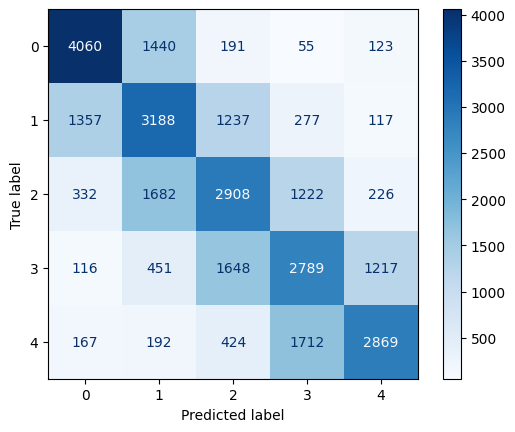

In [47]:
best_param = {'tol': 0.0006811855910220816, 'C': 0.8603850053519103, 'max_iter':1000}

embeddings = vectorize_custom_emb(df_train['text'].to_numpy()[:30000], w2vec_model, useSum=False)
lr_model = LogisticRegression(**best_param).fit(embeddings, df_train['label'].to_numpy()[:30000])

predictions = lr_model.predict(vectorize_custom_emb(df_test['text'].to_numpy()[:30000], w2vec_model, useSum=False))

print(classification_report(df_test['label'].to_numpy()[:30000], predictions))
ConfusionMatrixDisplay(confusion_matrix(df_test['label'].to_numpy()[:30000], predictions, labels = list(set(df_test['label'].to_numpy())))).plot(cmap='Blues')
plt.show()

The overall performances are similar to the other embeddings, class zero is better recognized wrt the classifier with pretrained embedding however the previous model has higher performances for class 4.

It could be said that our embedding model introduces a bias towards the negative class.

## Support Vector Machine

Continuing our exploration of the linear classifier world, we can try a support vector machine.
1. Tokenize the dataset, as usual
2. Create the model as a pipeline of a StandardScaler, to standardize the features of the dataset and a SGDClassifier, which uses Stochastic Gradient Descent to train a linear model.
3. Fit the model on the whole training dataset

In [33]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1, 2), lowercase=True, min_df=5, binary=False)

X_train = vectorizer.fit_transform(df_train["text"])
X_test = vectorizer.transform(df_test["text"])

y_train = df_train["label"].tolist()
y_test = df_test["label"].tolist()

In [34]:
tuning_on = False

if tuning_on:
    sgd_model = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge', shuffle=True, n_jobs=-1, random_state=0, learning_rate='optimal', early_stopping=True, class_weight='balanced'))

    param_grid = {
      'sgdclassifier__alpha': [0.01, 0.1, 1.0, 10.0, 20.0, 30.0],
      'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet'],
      'sgdclassifier__max_iter': [500, 1000, 1500],
      'sgdclassifier__tol': [1e-4, 1e-3, 1e-2]
    }
    grid_search = GridSearchCV(sgd_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f'Best parameters: {best_params}')

    sgd_model = grid_search.best_estimator_

else:
    sgd_model = make_pipeline(StandardScaler(with_mean=False),
                            SGDClassifier(loss='hinge',
                                          penalty='l2',
                                          alpha=30,
                                          max_iter=500,
                                          tol=1e-3,
                                          shuffle=True,
                                          n_jobs=-1,
                                          random_state=0,
                                          learning_rate='optimal',
                                          early_stopping=True,
                                          class_weight='balanced'))

    sgd_model.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.56      0.83      0.67     10000
           1       0.52      0.36      0.42     10000
           2       0.51      0.39      0.44     10000
           3       0.49      0.43      0.46     10000
           4       0.61      0.72      0.66     10000

    accuracy                           0.54     50000
   macro avg       0.54      0.54      0.53     50000
weighted avg       0.54      0.54      0.53     50000



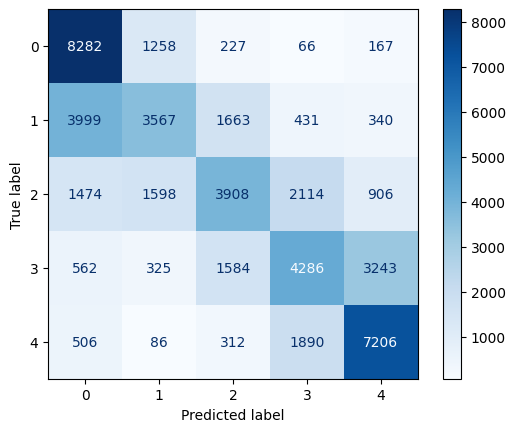

14392

In [36]:
predictions = sgd_model.predict(X_test)

print(classification_report(y_test, predictions))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions)).plot(cmap='Blues')
plt.show()

del sgd_model, vectorizer
gc.collect()

The performance of this model is not so different from the ones we have already tried.

By now we have explored a few linear models. <br>
Even though some perform better than others, we didn't get any amazing result, so it's time to explore other different types of models!

# Random Forest Classifier

Let's now give a try to a simple random forest classifier, which is based on decision trees.

1. Vectorize the whole training and test datasets, to extract training and test sets
2. Fit the model with the best parameters found during tuning phase
3. Test the model

In [37]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1, 2), lowercase=True, min_df=5, binary=False)

X_train = vectorizer.fit_transform(df_train["text"])
X_test = vectorizer.transform(df_test["text"])

y_train = df_train["label"].tolist()
y_test = df_test["label"].tolist()

In [38]:
tuning_on = False

if tuning_on:
    random_forest_model = RandomForestClassifier(criterion="gini", n_jobs=-1, random_state=0, class_weight='balanced')

    param_grid = {
      'n_estimators': [100, 300, 500],
      'max_depth': [None, 10, 30],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [5, 10],
    }
    grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f'Best parameters: {best_params}')

    random_forest_model = grid_search.best_estimator_

else:
    random_forest_model = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=5,
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

    random_forest_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 40.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 45.4min finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   26.1s finished


              precision    recall  f1-score   support

           0       0.58      0.80      0.67     10000
           1       0.51      0.40      0.45     10000
           2       0.50      0.41      0.45     10000
           3       0.49      0.41      0.44     10000
           4       0.58      0.68      0.62     10000

    accuracy                           0.54     50000
   macro avg       0.53      0.54      0.53     50000
weighted avg       0.53      0.54      0.53     50000



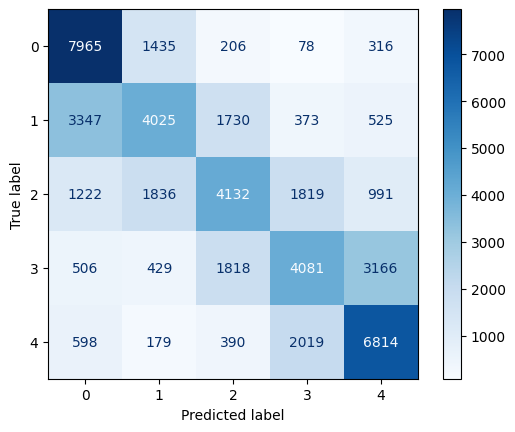

7142

In [39]:
predictions = random_forest_model.predict(X_test)

print(classification_report(y_test, predictions))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions)).plot(cmap='Blues')
plt.show()

del random_forest_model, vectorizer
gc.collect()

The model achieved an accuracy of 0.54, which is in line with all the previous models.

# Long Short-Term Memory (LSTM)

Let's now try LSTM.

In this case we use the tensorflow vectorizer, and since it doesn't perform the stopword removal, we first need to clean the dataset ourselves.

In [20]:
train_lstm = copy.deepcopy(df_train)
test_lstm = copy.deepcopy(df_test)
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

train_lstm.loc[:, 'text'] = train_lstm['text'].apply(remove_stopwords)
test_lstm.loc[:, 'text'] = test_lstm['text'].apply(remove_stopwords)

For performance reasons, we limit the vocabulary size to 30k and the tokenized text length to 200, as most reviews are shorter than that.

In [21]:
vectorizer = TextVectorization(max_tokens=30000, standardize='lower_and_strip_punctuation', split='whitespace', ngrams=(1, 2), output_sequence_length=200)
vectorizer.adapt(train_lstm['text'])

X_train = vectorizer(train_lstm['text'])
X_test = vectorizer(test_lstm['text'])

y_train = train_lstm['label']
y_test = test_lstm['label']

We create the model using 3 layers:
1. An embedding layer
2. An LSTM layer
3. A dense layer

and we train the model for 2 epochs on the whole training set, leaving out 20% of it for the validation.

Finally, we test the model as usual to compare with other models.

In [22]:
vocab_size = vectorizer.vocabulary_size() + 1

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=100))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(5, activation='softmax'))

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
lstm_model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2)

Epoch 1/2
16250/16250 ━━━━━━━━━━━━━━━━━━━━ 3336s 205ms/step - accuracy: 0.3367 - loss: 1.3927 - val_accuracy: 0.6376 - val_loss: 0.8402
Epoch 2/2
16250/16250 ━━━━━━━━━━━━━━━━━━━━ 3342s 206ms/step - accuracy: 0.6230 - loss: 0.8679 - val_accuracy: 0.6432 - val_loss: 0.8268


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 119s 76ms/step
              precision    recall  f1-score   support

           0       0.75      0.74      0.74     10000
           1       0.55      0.59      0.57     10000
           2       0.55      0.53      0.54     10000
           3       0.54      0.55      0.54     10000
           4       0.71      0.69      0.70     10000

    accuracy                           0.62     50000
   macro avg       0.62      0.62      0.62     50000
weighted avg       0.62      0.62      0.62     50000



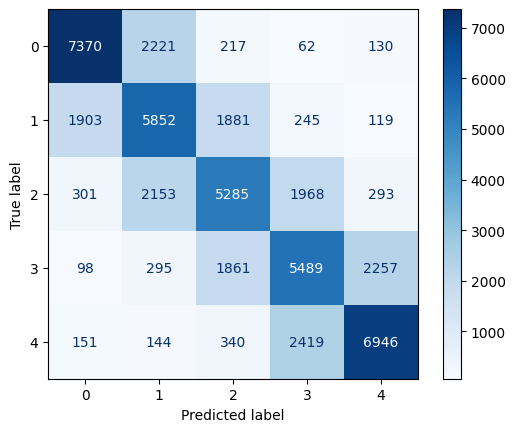

8453

In [24]:
predictions = lstm_model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

print(classification_report(y_test, predictions))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions)).plot(cmap='Blues')
plt.show()

del lstm_model, vectorizer
gc.collect()

The model has achieved a higher accuracy and f1 score!

As in the previous cases, the confusion matrix highlights that the model is able to make predictions close to the real rating, since the more colorful cells lie along the main diagonal.

# Transformer Models

Let's tune some transformer models.

For a fair comparison we trained for one epoch the three different models on 25% of the training data (done to comply with time constraints).

In [21]:
! mkdir bert_model
! mkdir distil_model
! mkdir xl_model

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Map:   0%|          | 0/162500 [00:00<?, ? examples/s]

Map:   0%|          | 0/487500 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Report for ---------bert-base-multilingual-uncased------------
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     10000
           1       0.58      0.60      0.59     10000
           2       0.59      0.57      0.58     10000
           3       0.56      0.56      0.56     10000
           4       0.73      0.71      0.72     10000

    accuracy                           0.64     50000
   macro avg       0.64      0.64      0.64     50000
weighted avg       0.64      0.64      0.64     50000



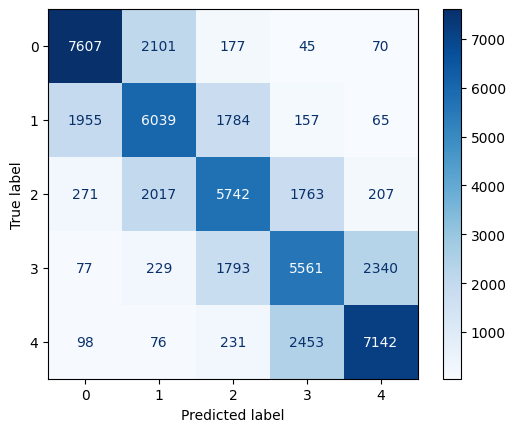

In [22]:
train_transformer('bert-base-multilingual-uncased', 'bert_model')

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/162500 [00:00<?, ? examples/s]

Map:   0%|          | 0/487500 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Report for ---------distilbert-base-uncased------------
              precision    recall  f1-score   support

           0       0.76      0.78      0.77     10000
           1       0.59      0.61      0.60     10000
           2       0.61      0.58      0.59     10000
           3       0.58      0.57      0.58     10000
           4       0.74      0.74      0.74     10000

    accuracy                           0.66     50000
   macro avg       0.66      0.66      0.66     50000
weighted avg       0.66      0.66      0.66     50000



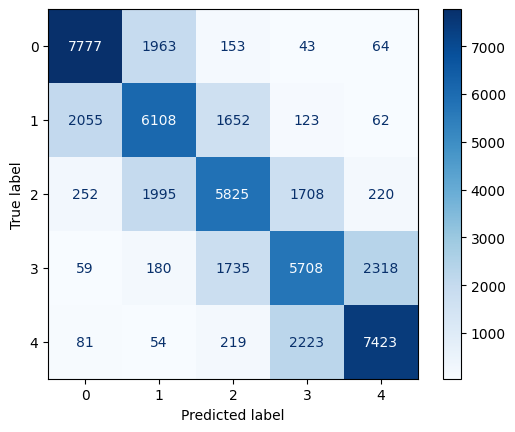

In [29]:
train_transformer('distilbert-base-uncased', 'distil_model')

XLNet is a transformer model trained to predict a token given any possible permutation of the input sequence.

This training method combined with a different architecture wrt Bert allow XLNet to reach SOTA performances.

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Map:   0%|          | 0/162500 [00:00<?, ? examples/s]

Map:   0%|          | 0/487500 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Report for ---------xlnet-base-cased------------
              precision    recall  f1-score   support

           0       0.78      0.79      0.79     10000
           1       0.62      0.63      0.63     10000
           2       0.64      0.61      0.62     10000
           3       0.60      0.59      0.60     10000
           4       0.74      0.77      0.76     10000

    accuracy                           0.68     50000
   macro avg       0.68      0.68      0.68     50000
weighted avg       0.68      0.68      0.68     50000



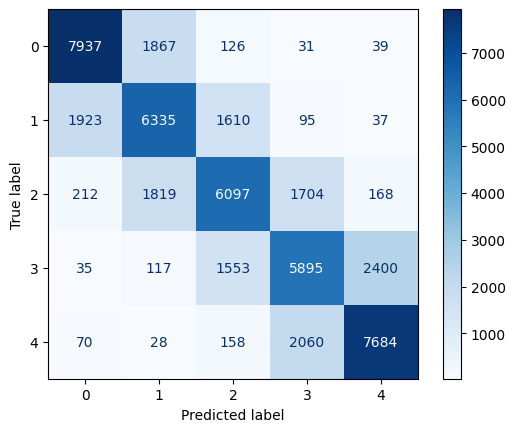

In [30]:
train_transformer('xlnet-base-cased', 'xl_model')

As we expected XLNet has the best performances with the drawback of an higher training time.

An interesting fact is that DistilBert performances are better than the ones of Bert in contrast with what we expected. Since the number of parameters of Bert is higher than DistilBert the reason of this behavior could be the fact that we gave too few training data and epoch to Bert compared to the number of parameters

What happens when we train the best model with more data and a higher number of epochs?<br>
In a different notebook we trained XLNet for two epochs with 50% of training data for 9 hours (maximum GPU runtime on Kaggle).<br>
We uploaded the obtained custom model to HuggingFace ('andrea-alari/best-yelp-xlnet') and used it to compare the results.<br>

In [31]:
model_name = 'andrea-alari/best-yelp-xlnet'
pipe = pipeline("text-classification", model=model_name, device=device)
answer = pipe(dataset['test']['text'])

y_pred = []
for el in answer:
    y_pred.append(int(el['label'][6]))

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/469M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

Report for ---------andrea-alari/best-yelp-xlnet------------
              precision    recall  f1-score   support

           0       0.80      0.81      0.81     10000
           1       0.65      0.66      0.66     10000
           2       0.67      0.65      0.66     10000
           3       0.63      0.63      0.63     10000
           4       0.77      0.78      0.77     10000

    accuracy                           0.71     50000
   macro avg       0.70      0.71      0.71     50000
weighted avg       0.70      0.71      0.71     50000



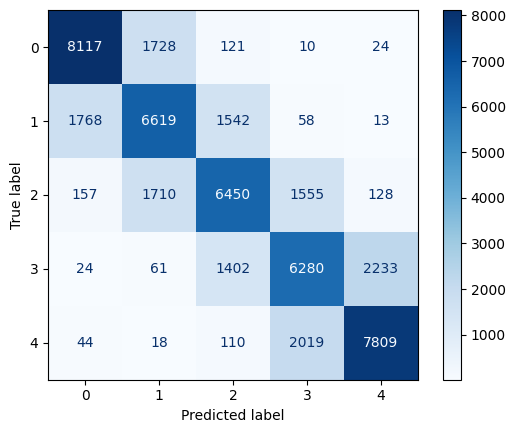

In [32]:
print(f'Report for ---------{model_name}------------')
print(classification_report(dataset['test']['label'], y_pred))
ConfusionMatrixDisplay(confusion_matrix(dataset['test']['label'], y_pred)).plot(cmap='Blues')
plt.show()

As we expected better performances are achived when we train the model with more data, in fact we increased by 3% the accuracy by doubling the train data.

Let's give zero shot learning a shot.
We use only 20% of the test samples since it's a very big model.

In [34]:
test_subset_bart = create_balanced_subset(df=df_test, label_column="label", sample_size=2000)
X_test = test_subset_bart['text'].tolist()
y_test = test_subset_bart['label'].tolist()

In [35]:
model_name = "facebook/bart-large-mnli"
pipe = pipeline(model= model_name, device=device)
answer = pipe(X_test,
    candidate_labels=["strong negative", "negative", "neutral", "positive", "strong positive"],
)

y_pred = []
mapping_labels = {"strong negative": 0, "negative": 1, "neutral": 2, "positive": 3, "strong positive": 4}
for el in answer:
    y_pred.append(mapping_labels[el['labels'][0]])

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Report for ---------facebook/bart-large-mnli------------
              precision    recall  f1-score   support

           0       0.51      0.11      0.19      2000
           1       0.36      0.87      0.51      2000
           2       0.72      0.03      0.07      2000
           3       0.39      0.53      0.44      2000
           4       0.54      0.53      0.53      2000

    accuracy                           0.41     10000
   macro avg       0.50      0.41      0.35     10000
weighted avg       0.50      0.41      0.35     10000



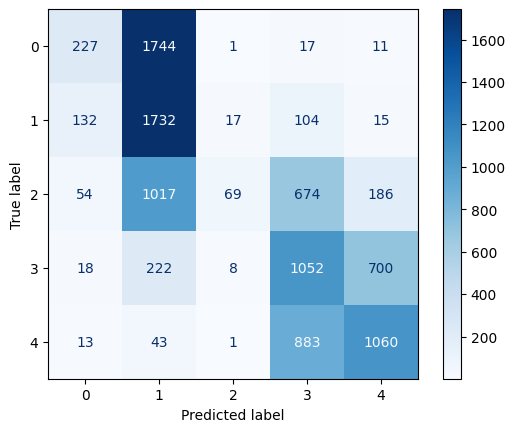

In [36]:
print(f'Report for ---------{model_name}------------')
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')
plt.show()

The result is poor, but since the model is performing zero-shot learning without any context, this is expected.

# Sentiment analysis
By now we have tried different models with the goal of predicting the rating. <br>
The general behavior we have observed is that most of the predictions lay along the main diagonal of the confusion matrix, which means that many wrong predictions were "close" to the real rating.<br>
For example, it is more likely that a 4-rated review is predicted as a 3-star, rather than 0-star one.

A prediction wrong of only 1 rating, is usually not considered a terrible mistake by people. <br>
In many cases we only focus on whether a review is either positively or negatively rated.

How would our consideration change if we only consider ratings as either 'positive' or 'negative'?
In the following, we will analyze some of the models we have already presented in the first part of the notebook, to see how they behave on this new task.

The labels are mapped to a sentiment as described in the following table:

| label | sentiment |
|-------|-----------|
| 0     | negative  |
| 1     | negative  |
| 2     | negative  |
| 3     | positive  |
| 4     | positive  |

In [19]:
def map_label_to_sentiment(label):
    if label in [0, 1, 2]:
        return 'negative'
    elif label in [3, 4]:
        return 'positive'

First we add to the train and test data the column 'sentiment', with values either 'positive' or 'negative', according to the rating. 

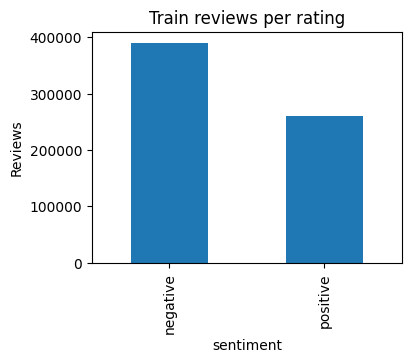

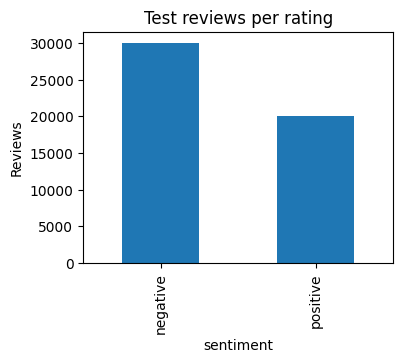

In [20]:
df_train['sentiment'] = df_train['label'].apply(map_label_to_sentiment)
plot_ratings(df_train, col='sentiment', title='Train reviews per rating')

df_test['sentiment'] = df_test['label'].apply(map_label_to_sentiment)
plot_ratings(df_test, col='sentiment', title='Test reviews per rating')

Since the reviews are not equally distributed, we will work on a balanced subset of the data.

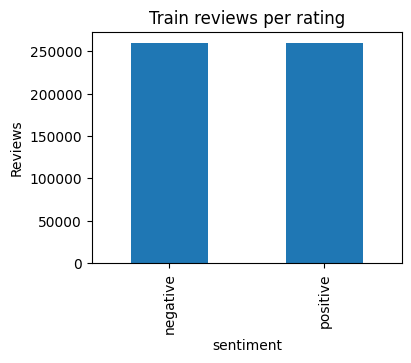

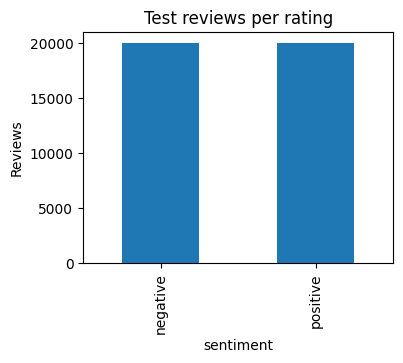

In [21]:
train_sentiment = create_balanced_subset(df=df_train, label_column="sentiment", sample_size=260000)
plot_ratings(train_sentiment, col='sentiment', title='Train reviews per rating')

test_sentiment = create_balanced_subset(df=df_test, label_column="sentiment", sample_size=20000)
plot_ratings(test_sentiment, col='sentiment', title='Test reviews per rating')

## BM25

As a first try, we use bm25 for sentiment analysis and see how it performs.

In [127]:
vectorized = bm25_vectorize(test_sentiment['text'])
labels = test_sentiment['sentiment']

bm25 = BM25Okapi(vectorized)

# Positive words
file = open('/kaggle/input/sentiment-analysis-word-lists-dataset/positive-words.txt', 'r')
positive_words = file.read()
file.close()

tokenized_query = positive_words.replace('\n',' ').split(" ")

pos_scores = bm25.get_scores(tokenized_query)
print('Positive scores for the first 10 elements')
print(pos_scores[:10])

# Negative words
file = open('/kaggle/input/sentiment-analysis-word-lists-dataset/negative-words.txt', 'r', encoding = "ISO-8859-1")
negative_words = file.read()
file.close()

tokenized_query = negative_words.replace('\n',' ').split(" ")

neg_scores = bm25.get_scores(tokenized_query)
print('Negative scores for the first 10 elements')
print(neg_scores[:10])

100%|██████████| 40000/40000 [00:03<00:00, 10208.41it/s]


Positive scores for the first 10 elements
[12.10394514 13.15283351  0.         52.7336144  26.69436876 13.64781913
  7.17825047  1.40068347  4.8201331  24.03662717]
Negative scores for the first 10 elements
[16.61645792 11.99580907  5.54625828  0.         20.35086566  7.33102223
  0.          0.          0.         13.66343874]


100%|██████████| 40000/40000 [00:00<00:00, 788651.31it/s]


              precision    recall  f1-score   support

    negative       0.78      0.57      0.66     20000
    positive       0.66      0.84      0.74     20000

    accuracy                           0.71     40000
   macro avg       0.72      0.71      0.70     40000
weighted avg       0.72      0.71      0.70     40000



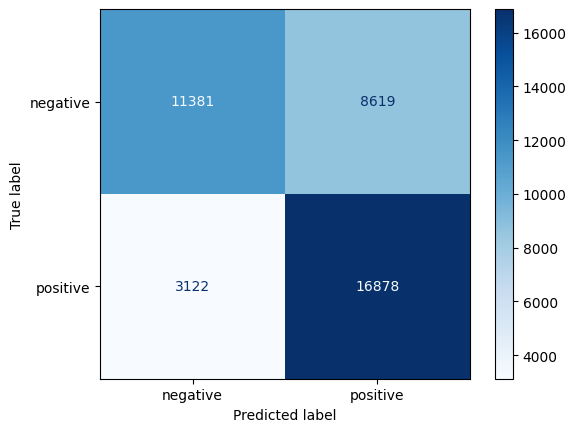

In [128]:
preds = []
for i in tqdm(range(len(vectorized))):
    if neg_scores[i] > pos_scores[i]:
        preds.append('negative')
    else:
        preds.append('positive')
        
print(classification_report(labels, preds, target_names=['negative', 'positive']))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(labels, preds), display_labels=['negative', 'positive']).plot(cmap='Blues')
plt.show()

As we expected, we obtained a higher f1 score on this task wrt to the rating prediction, since it's simpler.

In the following you can see the best and the worst reviews retrieved.

In [129]:
best = np.argmax(pos_scores)
print('Best Review:')
print(dataset['test']['text'][best])

worst = np.argmax(neg_scores)
print('Worst Review:')
print(dataset['test']['text'][worst])

gc.collect()

Best Review:
I came here for a routine oil change... they came back and shoved a bunch of unwanted information at me saying I need to have X and Y changed. The repairs would cost me over 2000, so I said no. Aside from making me feel stupid, when I went to check my oil a couple months later, I realized some screws were missing from underneath the hood. The ones that were there weren't secured properly. And somehow my hood prop rod also magically broke somehow. \n\nAlso, I came here once before that (this is before I noticed the missing pieces) because I noticed my check engine light was on. The first thing they threw at me was a 100 dollar diagnosis check. I could get those at other places for 15 dollars. again when I refused service, the technician just kept giving me the weirdest look like I was the dumbest customer to ever grace his presence. \n\nbottom line: Sub par service and work. I will never come here again even if it is close to my house.
Worst Review:
Good pizza; super yummy.

26619

## Logistic regression with TF-IDF vectorization

To try the Logistic Regressor with the TF-IDF vectorization, we use the same procedure we already explained for the rating prediction.

In [57]:
tfidf_vectorizer_sent = TfidfVectorizer(min_df=10, stop_words='english', max_features=5000, ngram_range=(1, 2))

X_train = tfidf_vectorizer_sent.fit_transform(train_sentiment['text'])
X_test = tfidf_vectorizer_sent.transform(test_sentiment['text'])

y_train = train_sentiment['sentiment']
y_test = test_sentiment['sentiment']

In [58]:
tuning_on = False
solv = 'sag'

if tuning_on:
    model = LogisticRegression(max_iter=100, solver=solv, warm_start=True)

    param_grid = {
        'C': [0.01, 0.1, 1.0, 10.0],
        'tol': [0.001, 0.01, 0.1]
    }
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f'Best parameters: {best_params}')

    logreg_tfidf_sent_model = grid_search.best_estimator_

else:
    logreg_tfidf_sent_model = LogisticRegression(solver=solv, warm_start=True, C=1.0, tol=0.001)
    logreg_tfidf_sent_model.fit(X_train, y_train)

              precision    recall  f1-score   support

    negative       0.87      0.86      0.86     20000
    positive       0.86      0.87      0.86     20000

    accuracy                           0.86     40000
   macro avg       0.86      0.86      0.86     40000
weighted avg       0.86      0.86      0.86     40000



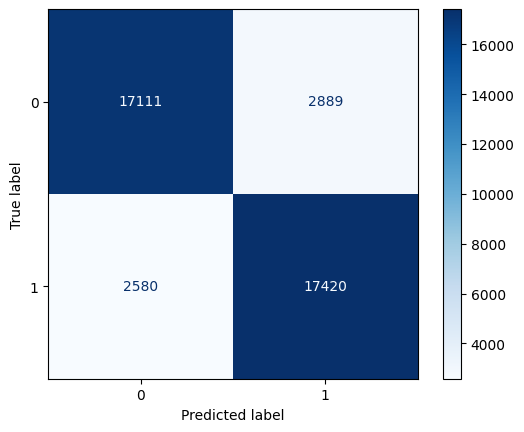

In [29]:
pred_sent = logreg_tfidf_sent_model.predict(X_test)

print(classification_report(y_test, pred_sent))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_sent)).plot(cmap='Blues')
plt.show()

This is a nice result! As we expected, it's easier for the model to say if a review is good or not, rather than predicting the exact rating.

## LSTM

Let's now see how LSTM behaves on the sentiment analysis task.

In [22]:
train_lstm = copy.deepcopy(train_sentiment)
test_lstm = copy.deepcopy(test_sentiment)

In [23]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

train_lstm.loc[:, 'text'] = train_lstm['text'].apply(remove_stopwords)
test_lstm.loc[:, 'text'] = test_lstm['text'].apply(remove_stopwords)

In [24]:
vectorizer = TextVectorization(max_tokens=30000, standardize='lower_and_strip_punctuation', split='whitespace', ngrams=(1, 2), output_sequence_length=200)
vectorizer.adapt(train_lstm['text'])

X_train = vectorizer(train_lstm['text'])
X_test = vectorizer(test_lstm['text'])

label_mapping = {'positive': 1, 'negative': 0}
y_train = train_lstm['sentiment'].map(label_mapping)
y_test = test_lstm['sentiment'].map(label_mapping)

In [25]:
vocab_size = vectorizer.vocabulary_size() + 1

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=100))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
lstm_model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2)

Epoch 1/2
13000/13000 ━━━━━━━━━━━━━━━━━━━━ 3788s 291ms/step - accuracy: 0.6722 - loss: 0.5378 - val_accuracy: 0.8794 - val_loss: 0.2833
Epoch 2/2
13000/13000 ━━━━━━━━━━━━━━━━━━━━ 3736s 286ms/step - accuracy: 0.8938 - loss: 0.2531 - val_accuracy: 0.8809 - val_loss: 0.2786


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 137s 109ms/step
              precision    recall  f1-score   support

    negative       0.90      0.86      0.88     20000
    positive       0.87      0.90      0.89     20000

    accuracy                           0.88     40000
   macro avg       0.88      0.88      0.88     40000
weighted avg       0.88      0.88      0.88     40000



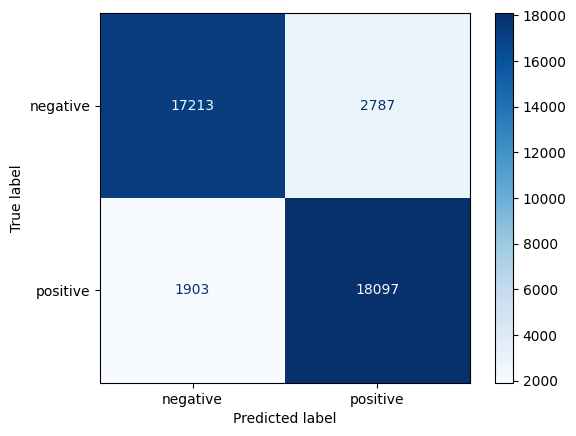

16293

In [27]:
predictions = lstm_model.predict(X_test)
predictions = np.round(predictions)

print(classification_report(y_test, predictions, target_names=['negative', 'positive']))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions), display_labels=['negative', 'positive']).plot(cmap='Blues')
plt.show()

del vectorizer, lstm_model
gc.collect()

The result is in line with the previous one.

## Distilbert

We've only just warmed up, but now it's time to bring out the big guns with the Transformers!

In [26]:
def map_sentiment(sentiment):
    return 0 if sentiment == 'negative' else 1

In [27]:
train_bert = copy.deepcopy(train_sentiment)
test_bert = deepcopy(test_sentiment)

In [28]:
train_bert.loc[:, 'label'] = train_bert['sentiment'].apply(map_sentiment)
test_bert.loc[:, 'label'] = test_bert['sentiment'].apply(map_sentiment)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/130000 [00:00<?, ? examples/s]

Map:   0%|          | 0/390000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Report for ---------distilbert-base-uncased------------
              precision    recall  f1-score   support

    negative       0.92      0.89      0.90     20000
    positive       0.89      0.92      0.91     20000

    accuracy                           0.90     40000
   macro avg       0.90      0.90      0.90     40000
weighted avg       0.90      0.90      0.90     40000



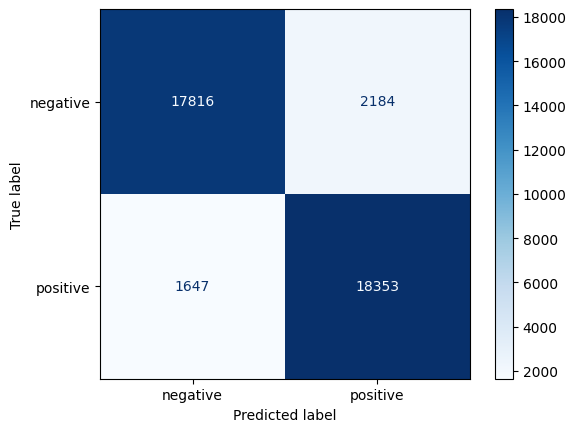

In [29]:
trainer_bert, tokenizer_bert = train_transformer_polarity('distilbert-base-uncased', 'distil_model', train_bert, test_bert)

Ok it's a good result, but not to far from the previous scores.

## Pretrained Bert

Let's see if a model pretrained on this specific task is able to surprise us.

In [30]:
X_test = test_bert['text'].tolist()
y_test = test_bert['label'].tolist()

In [31]:
model_name = 'textattack/bert-base-uncased-yelp-polarity'
pipe = pipeline("text-classification", model=model_name, device=device, truncation=True)
answer = pipe(X_test)

y_pred = []
for el in answer:
    y_pred.append(int(el['label'][6]))

config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Report for ---------textattack/bert-base-uncased-yelp-polarity------------
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     20000
           1       0.85      0.98      0.91     20000

    accuracy                           0.91     40000
   macro avg       0.91      0.91      0.91     40000
weighted avg       0.91      0.91      0.91     40000



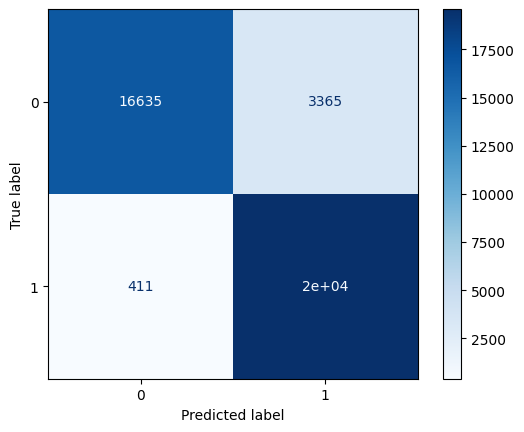

5246

In [32]:
print(f'Report for ---------{model_name}------------')
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')
plt.show()

del pipe
gc.collect()

A little bit better! But slightly below the SOTA performance stated on hugging face.

# Test on a different dataset
Now we can try to test some of our models on a different dataset.<br>
We will try both the rating prediction and the sentiment analysis.

We will work on an amazon dataset, with reviews of mobile electronics. After downloading the dataset, we will show it to see the information it provides.

In [33]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [72]:
dataset_amazon = load_dataset("rkf2778/amazon_reviews_mobile_electronics")

In [73]:
df_amazon_train = pd.DataFrame(dataset_amazon['train'])
df_amazon_test = pd.DataFrame(dataset_amazon['test'])
df_amazon = pd.concat([df_amazon_train, df_amazon_test], axis=0, ignore_index=True)
df_amazon[:6]

customer_id  \
0     28471074   
1      1958232   
2     49126521   
3     46531276   
4      4487344   
5     32141833   

                                                                                                                                                                                                                       product_title  \
0                                                                                                                                          Sprint Universal Folding Portable Mini Stereo Speakers (Retail Packaging) by AccessoryOne   
1                             iXCC Lightning Cable 3ft, iPhone charger, for iPhone X, 8, 8 Plus, 7, 7 Plus, 6s, 6s Plus, 6, 6 Plus, SE 5s 5c 5, iPad Air 2 Pro, iPad mini 2 3 4, iPad 4th Gen [Apple MFi Certified](Black and White)   
2                                                                                                                                                                                        Sennheiser HMEC 250 NoiseGard Pilot Headset   
3                                                                                                                                                      M-Edge Touring Sleeve for Kindle (Fits 6" Display, Latest Generation), Orange   
4                               iPod Touch 5th 6th Generation Case MyTurtle TM Apple iPod Touch 5 Touch 6 Shockproof Hybrid 3 Layer Premium Silicone Shell Cover Stylus Pen + 3x Screen Protector (Teal Green Glowing Electric Pink)   
5  GSI Quality Waterproof Bluetooth Intercom System for Motorcycles/Motorbikes - Connect Up to 4 Riders At Max Distance - 2-Way Radio Helmet Headset - Connects to Bluetooth Mobile Phones and MP3 Players - Wireless Remote Control   

   star_rating  \
0            5   
1            5   
2            2   
3            5   
4            5   
5            3   

                                                                                                                                                                                                                                                                                                                                                                                                                      review_body  \
0                                                                                                                                                                                                                                                                                                                     Item was as discribed ; was shipped fast and function very well . Would do business with again .<br />A++++   
1                                                                                                                                                                                                                                                                                                                                                                                                Came in perfect. Works perfectly   
2                                                                                                                                                                                                                                                                Good quality, came with out the extra boom mic cushion and the cord holder that the manufacturer promotes on the included parts off the product (product manual)   
3                                                                                                                                                                                       I do not like reading my Kindle in a case so this sleeve is great.  Good protection for my Kindle.  The front pocket is small.  I use it to keep a list of series books.  You could keep your charger in it but the pocket will stick up.   
4                  

The columns we are interested in are "star_rating",  "review_body" and "star_rating_label". <br>

We create the columns "label", with the star ratings shifted by 1, to obtain a 0-4 rating, as in yelp.<br>
Then we drop the columns we don't need.

In [74]:
df_amazon.fillna({'review_body': ''}, inplace=True)

df_amazon['label'] = df_amazon['star_rating'] - 1

columns_to_drop = ['customer_id', 'product_title', 'star_rating', 'product_id']
df_amazon = df_amazon.drop(columns_to_drop, axis=1)
df_amazon[:6]

review_body  \
0                                                                                                                                                                                                                                                                                                                     Item was as discribed ; was shipped fast and function very well . Would do business with again .<br />A++++   
1                                                                                                                                                                                                                                                                                                                                                                                                Came in perfect. Works perfectly   
2                                                                                                                                                                                                                                                                Good quality, came with out the extra boom mic cushion and the cord holder that the manufacturer promotes on the included parts off the product (product manual)   
3                                                                                                                                                                                       I do not like reading my Kindle in a case so this sleeve is great.  Good protection for my Kindle.  The front pocket is small.  I use it to keep a list of series books.  You could keep your charger in it but the pocket will stick up.   
4                                                                                                                                                                                                                                                                               The case came 3 days after I ordered it. It fits my iPod really well and the colors are really cute. Only issue was the missing screen protectors   
5  I really like the GSI Quality Waterproof Bluetooth Intercom System for Motorcycles/Motorbikes - The 2-Way Radio and Bluetooth works great. The only problem is the helmet clip. I have use glue, powerful adhesives and it stays on until I bump helmet against something and it breaks again. This becomes frustrating, especially after 5 breaks. Therefore, in my opinion I suggest not to purchase this item find another.   

  star_rating_label  label  
0          positive      4  
1          positive      4  
2          negative      1  
3          positive      4  
4          positive      4  
5          negative      2

At this point, the Amazon dataset contains the same information of the YELP dataset we trained our models on, so we are ready to start!

## Rating prediction

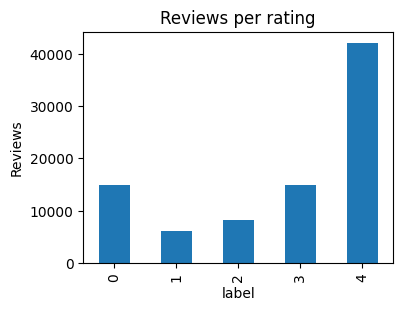

In [75]:
plot_ratings(df_amazon, col='label', title='Reviews per rating')

The reviews per rating are not balanced.

Since our test set has been balanced until now, we have decided to continue using a balanced subset for the Amazon dataset to ensure a fair comparison across each class individually.<br>
Although a weighted value is presented at the end of the report, allowing us to skip balancing, we chose to balance the test set to enable a fair analysis of the model's performance across all rating categories.

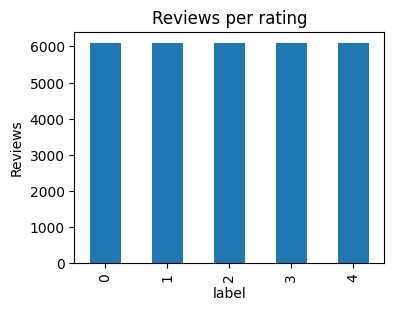

In [76]:
amazon_subset = create_balanced_subset(df=df_amazon, label_column='label', sample_size=6100)
plot_ratings(amazon_subset, col='label', title='Reviews per rating')

In the following, we evaluate the Logistic Regressor model (with TF-IDF vectorization), and the best tranformer that we have obtained trained on yelp reviews.

### Logistic Regressor with TF-IDF vectorization

In [46]:
X_test = tfidf_vectorizer.transform(amazon_subset['review_body'])
y_test = amazon_subset['label']

              precision    recall  f1-score   support

           0       0.43      0.70      0.53      6100
           1       0.31      0.25      0.27      6100
           2       0.33      0.26      0.29      6100
           3       0.37      0.26      0.31      6100
           4       0.49      0.52      0.50      6100

    accuracy                           0.40     30500
   macro avg       0.38      0.40      0.38     30500
weighted avg       0.38      0.40      0.38     30500



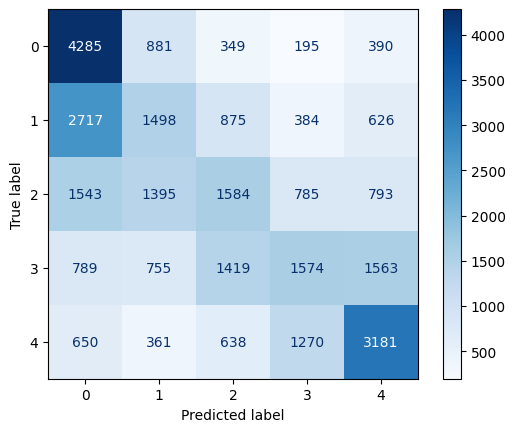

In [48]:
pred_amazon_rating = logreg_tfidf_model.predict(X_test)

print(classification_report(y_test, pred_amazon_rating))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_amazon_rating)).plot(cmap='Blues')
plt.show()

### XLNet

In [49]:
X_test_list = amazon_subset['review_body'].tolist()
y_test_list = amazon_subset['label'].tolist()

In [50]:
model_name = 'andrea-alari/best-yelp-xlnet'
pipe = pipeline("text-classification", model=model_name, device=device)
answer = pipe(X_test_list)

y_pred = []
for el in answer:
    y_pred.append(int(el['label'][6]))

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/469M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

Report for ---------andrea-alari/best-yelp-xlnet------------
              precision    recall  f1-score   support

           0       0.60      0.72      0.66      6100
           1       0.46      0.44      0.45      6100
           2       0.45      0.52      0.48      6100
           3       0.52      0.47      0.49      6100
           4       0.72      0.57      0.64      6100

    accuracy                           0.54     30500
   macro avg       0.55      0.54      0.54     30500
weighted avg       0.55      0.54      0.54     30500



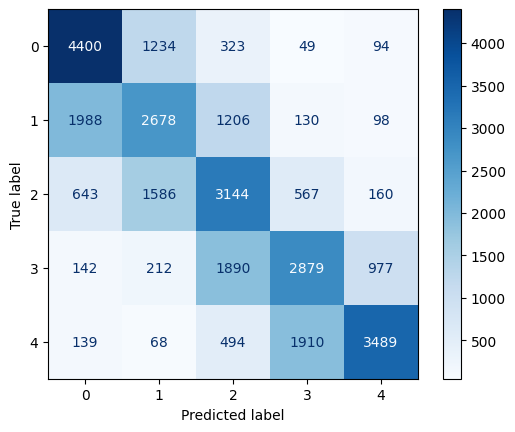

In [51]:
print(f'Report for ---------{model_name}------------')
print(classification_report(y_test_list, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test_list, y_pred)).plot(cmap='Blues')
plt.show()

The models trained on YELP didn't perform very well on the Amazon dataset. However, the distribution still lies along the diagonal, so we expect the sentiment analysis to yield good results.

## Sentiment Analysis

First we need to take a balanced subset, for the same reasons explained before, this time according to the sentiment column.

We'll then test the Logistic Regressor with TF-IDF vectorization, and distilbert.

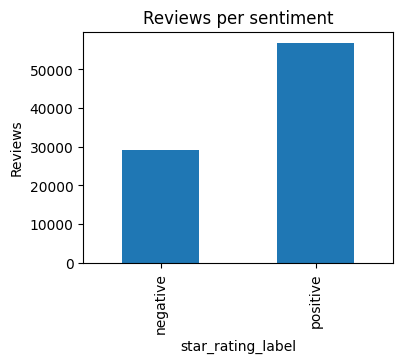

In [77]:
plot_ratings(df_amazon, col='star_rating_label', title='Reviews per sentiment')

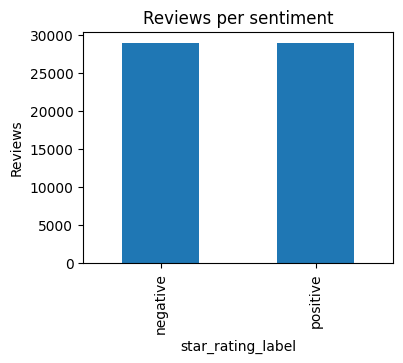

In [96]:
amazon_subset = create_balanced_subset(df=df_amazon, label_column='star_rating_label', sample_size=29000)
plot_ratings(amazon_subset, col='star_rating_label', title='Reviews per sentiment')

### Logistic Regressor with TF-IDF vectorization

In [59]:
X_test = tfidf_vectorizer_sent.transform(amazon_subset['review_body'])
y_test = amazon_subset['star_rating_label']

              precision    recall  f1-score   support

    negative       0.74      0.82      0.78     29000
    positive       0.80      0.71      0.75     29000

    accuracy                           0.76     58000
   macro avg       0.77      0.76      0.76     58000
weighted avg       0.77      0.76      0.76     58000



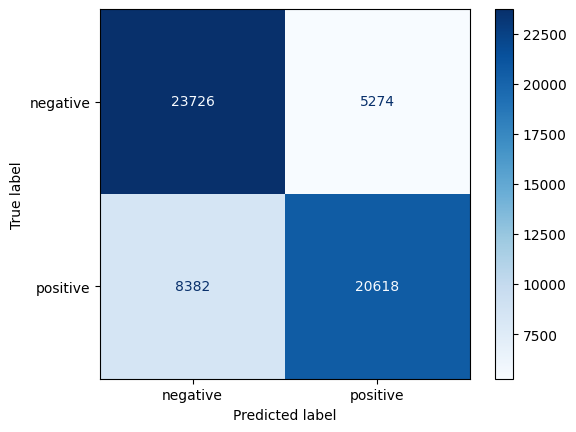

In [60]:
pred_sent = logreg_tfidf_sent_model.predict(X_test)

print(classification_report(y_test, pred_sent, target_names=['negative', 'positive']))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_sent), display_labels=['negative', 'positive']).plot(cmap='Blues')
plt.show()

### Distilbert

In [97]:
amazon_distilbert = copy.deepcopy(amazon_subset)

In [100]:
amazon_distilbert['label'] = amazon_distilbert['star_rating_label'].apply(map_sentiment)

In [103]:
def tokenize_function(dataset):
    return tokenizer_bert(dataset["text"], padding=True, truncation=True, max_length=256)

test_data = Dataset.from_list([{'text': txt, 'label': lbl} for txt, lbl in zip(amazon_distilbert['review_body'], amazon_distilbert['label'])])
tokenized_test_data = test_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/58000 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

    negative       0.85      0.91      0.88     29000
    positive       0.91      0.84      0.87     29000

    accuracy                           0.88     58000
   macro avg       0.88      0.88      0.88     58000
weighted avg       0.88      0.88      0.88     58000



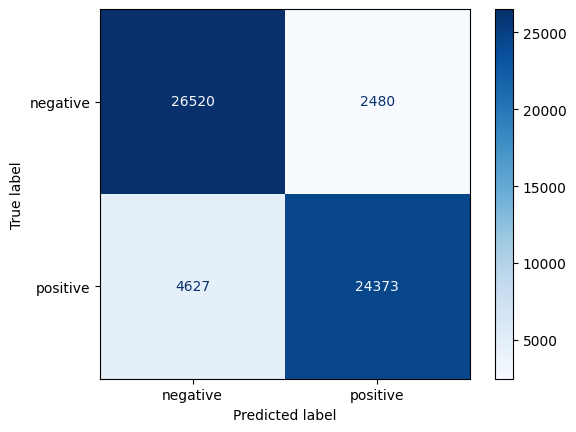

14213

In [105]:
preds = trainer_bert.predict(tokenized_test_data)
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()

print(classification_report(amazon_distilbert['label'], y_pred, target_names=['negative', 'positive']))
ConfusionMatrixDisplay(confusion_matrix(amazon_distilbert['label'], y_pred), display_labels=['negative', 'positive']).plot(cmap='Blues')
plt.show()

del tokenizer_bert, trainer_bert
gc.collect()

As we expected, the models trained on YELP performed well on a different subset in the sentiment analysis task.<br>
This highlights that predicting the exact rating is not an easy task, and the model might not perform well on new data. <br>
However, the wrong predictions are not too far from the real rating, as shown by the strong presence of the main diagonal. For these reasons, the sentiment analysis task works well on a different dataset.

# Conclusions
The following tables report the f1-score of each model. 

We observe that all models perform better on sentiment analysis than on rating prediction. It is easier to classify a text as 'positive' or 'negative' than to predict an exact rating.

Transformers have proven to be the best models for all tasks, outperforming other model, as expected.

Testing models trained on YELP with a different dataset showed significantly worse results for rating prediction, possibily because the content of the two datasets belongs to different domains.
Sentiment analysis results remained instead relatively good, and this suggests that sentiment analysis generalizes better to new data.

## Rating prediction on YELP

| Model                                        | f1-score |
|----------------------------------------------|----------|
| Clustering                                   | 0.21     |
| Logistic Regressor (Count)                   | 0.56     |
| Logistic Regressor (TF-IDF)                  | 0.58     |
| Logistic Regressor (Embeddings)              | 0.53     |
| Support Vector Machine                       | 0.53     |
| Random Forest Classifier                     | 0.53     |
| LSTM                                         | 0.62     |
| Transformer (bert-base-multilingual-uncased) | 0.64     |
| Transformer (distilbert-base-uncase)         | 0.66     |
| Transformer (xlnet-base-cased)               | 0.68     |
|**Transformer (andrea-alari/best-yelp-xlnet)**| **0.71** |

## Sentiment analysis on YELP

| Model                                           | f1-score |
|-------------------------------------------------|----------|
| BM25                                            | 0.70     |
| Logistic Regressor (TF-IDF)                     | 0.86     |
| LSTM                                            | 0.88     |
| Transformer (distilbert-base-uncase)            | 0.90     |
|**Transformer (bert-base-uncased-yelp-polarity)**| **0.91** |

## Rating prediction on Amazon

| Model                                        | f1-score |
|----------------------------------------------|----------|
| Logistic Regressor (TF-IDF)                  | 0.38     |
|**Transformer (andrea-alari/best-yelp-xlnet)**| **0.54** |

## Sentiment analysis on Amazon

| Model                                        | f1-score |
|----------------------------------------------|----------|
| Logistic Regressor (TF-IDF)                  | 0.76     |
| **Transformer (distilbert)**                 | **0.88** |